# Building Energy Efficiency Prediction Project

### Problem Statement
The objective is to accurately predict the energy consumption of buildings to help in the design of energy-efficient structures. Accurately predicting **Heating Load** and **Cooling Load** is a key step in this process.

### Project Goal
The goal is to build a highly accurate machine learning model that can predict both the Heating Load and Cooling Load of a residential building based on its physical characteristics. The project aims to achieve this by exploring and comparing various regression models, including a stacking regressor to optimize performance.

## 1. Importing Libraries and Loading the Dataset

In [1]:
# Essential libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for data preprocessing and modeling
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer

# Models to be used
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

In [2]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set a random seed for reproducibility
RANDOM_STATE = 42

# Load the dataset
try:
    df = pd.read_csv('D:/Downloads/energy_efficiency_data.csv')
    print("Dataset Loaded successfully")
except FileNotFoundError:
    print("File not found. Please check the file path.")

Dataset Loaded successfully


## 2. Initial EDA on unprocessed Data

In [3]:
# Display the first 5 rows of the dataframe
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
# Get a concise summary of the DataFrame
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [5]:
# Get descriptive statistics for numerical features
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [6]:
# Check for missing values
print("\nMissing values per column:")
df.isnull().sum()


Missing values per column:


Relative_Compactness         0
Surface_Area                 0
Wall_Area                    0
Roof_Area                    0
Overall_Height               0
Orientation                  0
Glazing_Area                 0
Glazing_Area_Distribution    0
Heating_Load                 0
Cooling_Load                 0
dtype: int64

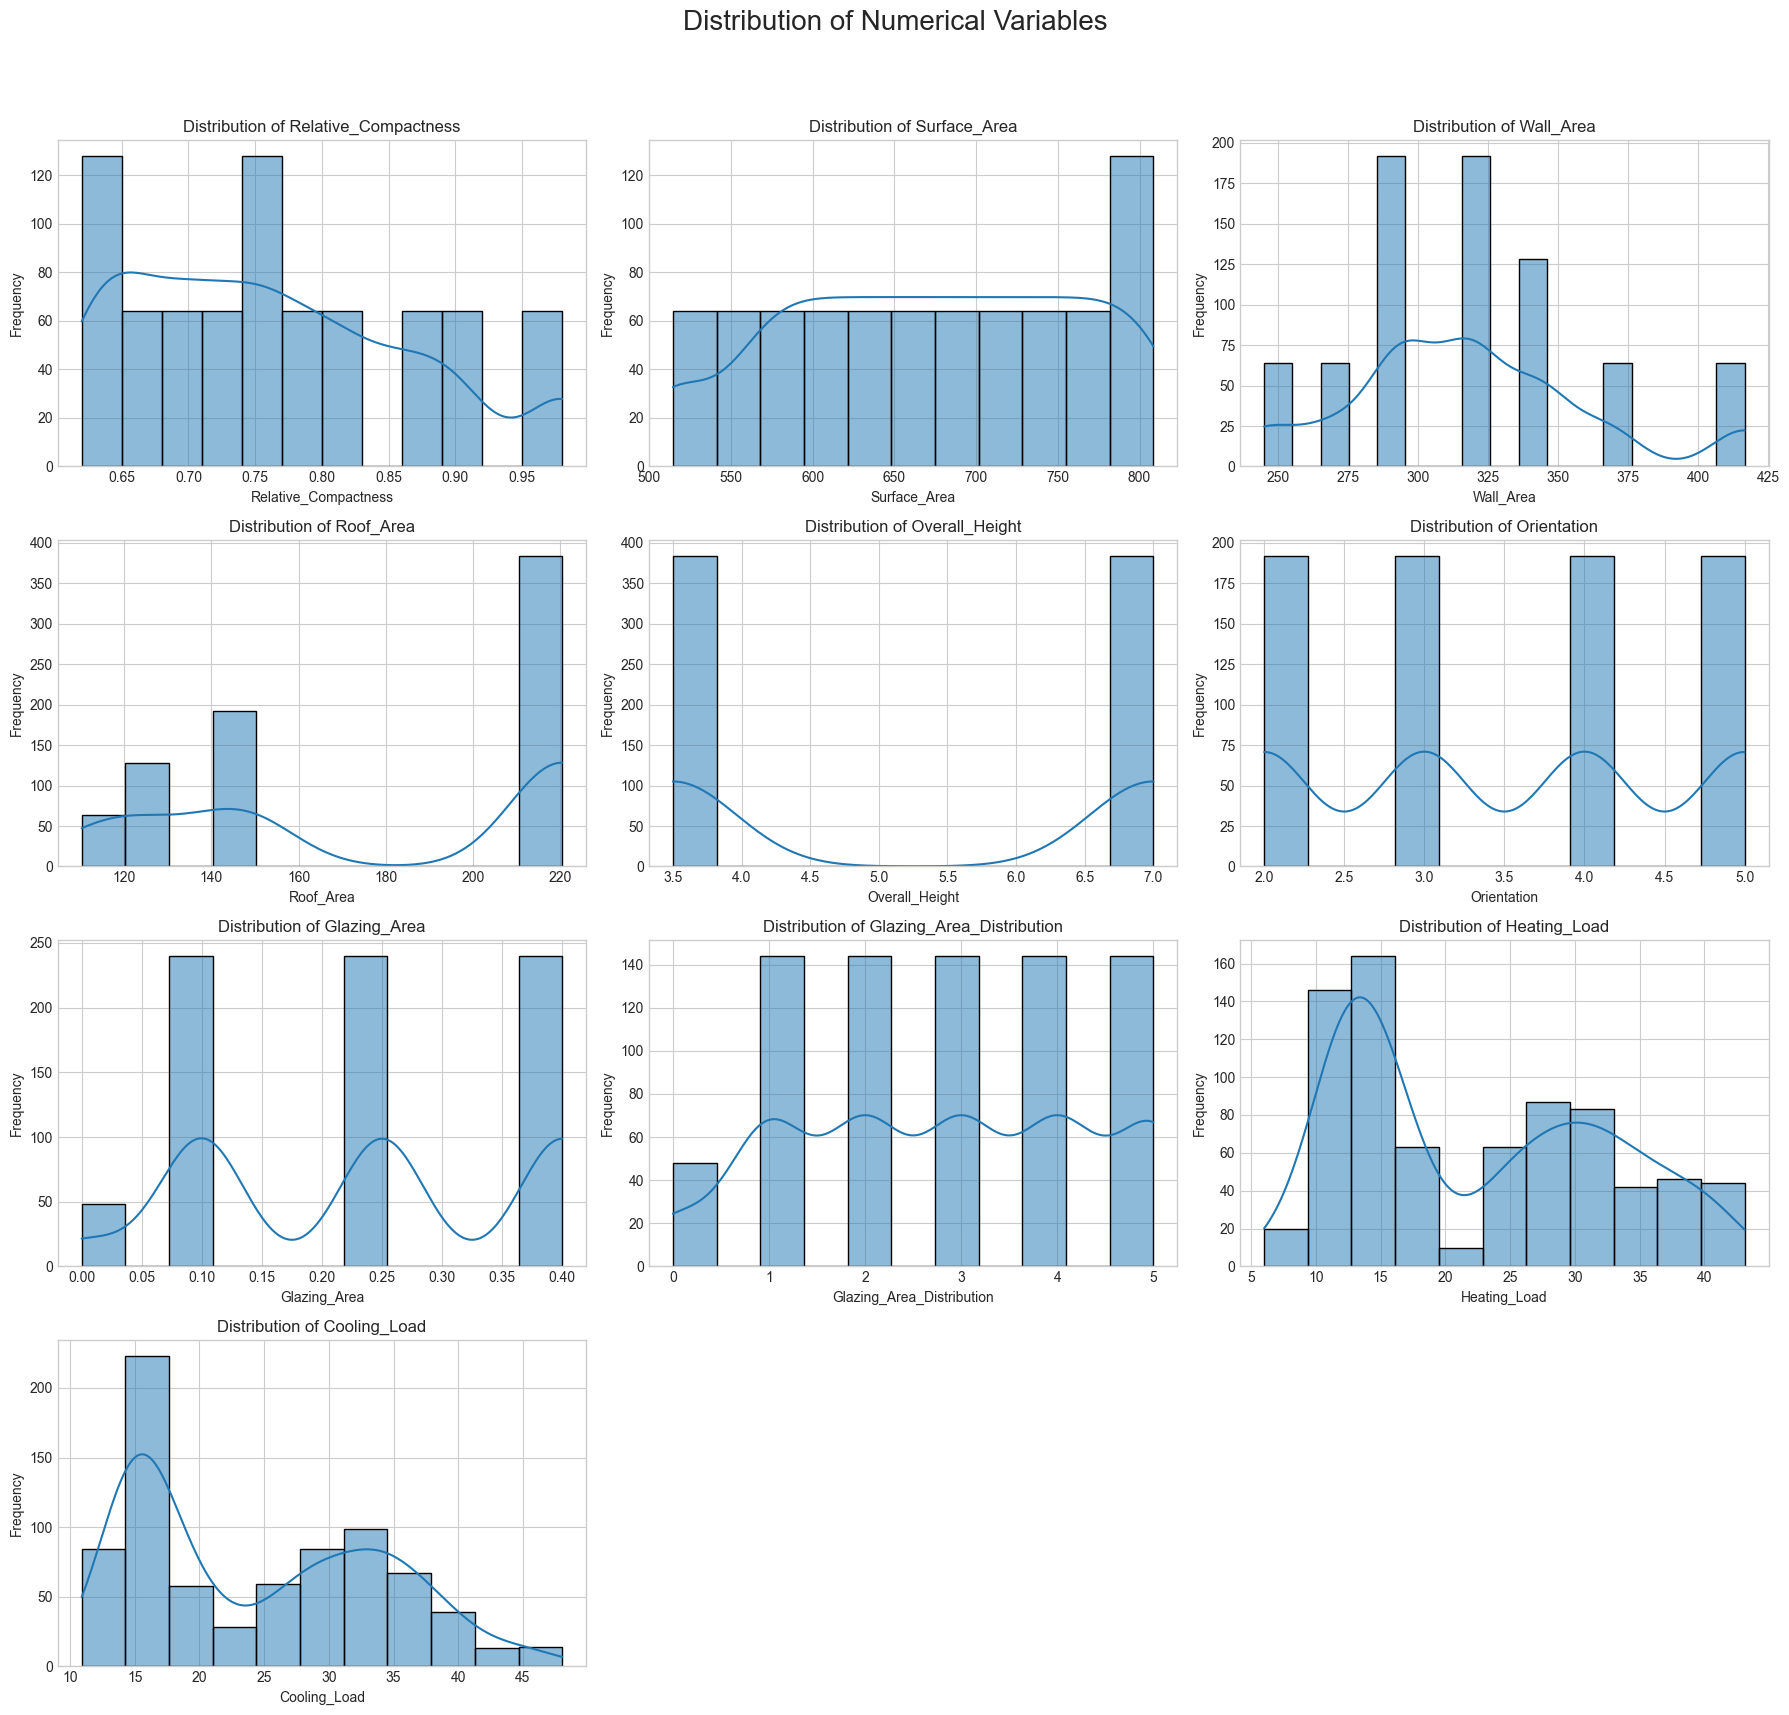

In [7]:
# Visualize the distribution of all unprocessed numerical columns
numerical_cols = df.columns.tolist() # All columns are numerical in this dataset

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 3, figsize=(18, 18))
fig.suptitle('Distribution of Numerical Variables', fontsize=20)

for i, col in enumerate(numerical_cols):
    row = i // 3
    col_idx = i % 3
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequency')

# Hide any empty subplots
if len(numerical_cols) < 12:
    for i in range(len(numerical_cols), 12):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **Analysis of Numerical Distributions**
- **Bimodal and Multimodal Features:** Several features, including `Relative_Compactness`, `Surface_Area`, `Wall_Area`, `Roof_Area`, and `Overall_Height`, show clear bimodal or multimodal distributions. This suggests that the dataset contains a few distinct groups of buildings with different physical dimensions, rather than a continuous spread of measurements. For example, the `Overall_Height` plot shows two distinct peaks.
    - **`Overall_Height`:** We should consider treating `Overall_Height` as a **categorical feature** in our analysis and modeling. While `Overall_Height` is stored as a numerical data type (float), its meaning in the context of this dataset is fundamentally categorical. The values 3.5 and 7.0 are not a continuous range. They likely represent two distinct building types—for example, one-story and two-story buildings. The difference between these two categories is not a simple numerical scale; it represents a qualitative difference in building design, which in turn has a strong, distinct impact on energy consumption.


- **Categorical Features:** The plots for `Orientation` and `Glazing_Area_Distribution` show that these are not continuous numerical variables but rather categorical or ordinal features. Their values are discrete integers (e.g., 2, 3, 4, 5 for `Orientation`). It's important to treat these as such during analysis and potentially one-hot encode them for some model types, although tree-based models can handle them as they are.

- **`Glazing_Area`:** This variable also exhibits a multimodal distribution with distinct peaks, indicating a few standardized window-to-wall ratios were used in the buildings.

#### **Analysis of Target Distributions**
- **Non-Normal Distribution:** The target variables, `Heating_Load` and `Cooling_Load`, are not normally distributed. Both are positively skewed, with their values concentrated on the lower end and a long tail extending toward higher energy loads.

- **Multimodality:** Like the features, the target variables also appear to be multimodal. This suggests that different groups of buildings in the dataset have different typical energy consumption profiles, which is a key insight our model will need to learn.

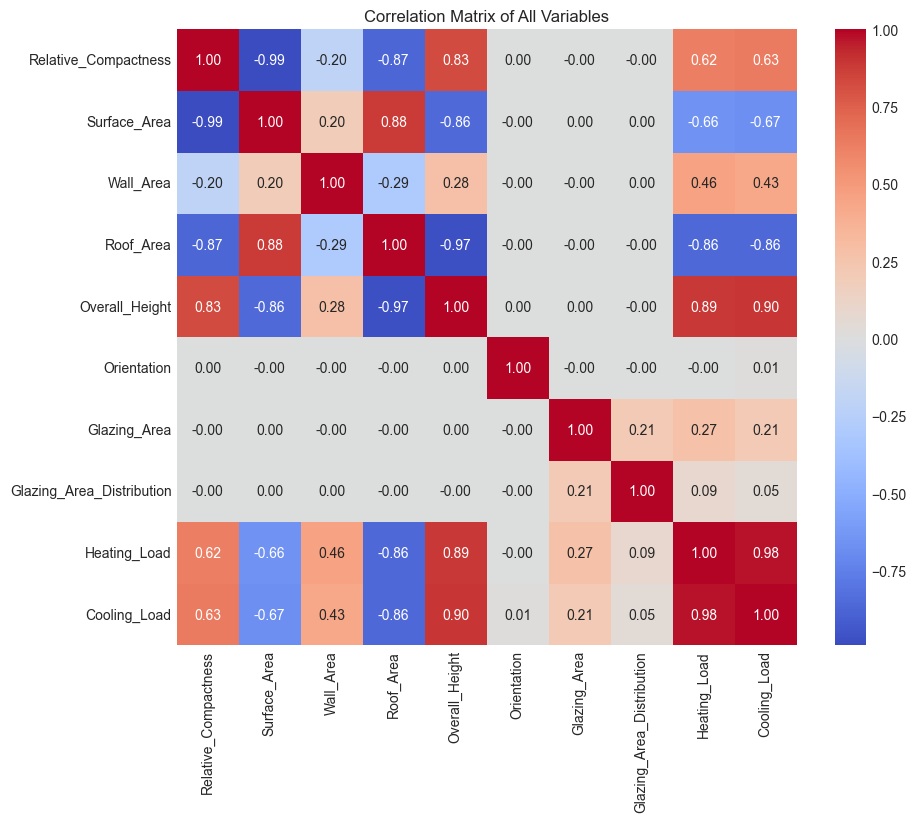

In [8]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Variables')
plt.show()

### Analysis of Correlation Heatmap

The correlation heatmap provides crucial insights into the linear relationships between the features and targets in the dataset.

#### 1. Strongest Feature-to-Target Correlations 🎯

* **Positive Correlations:**
    * `Overall_Height` has a very strong positive correlation with both `Heating_Load` (0.89) and `Cooling_Load` (0.90).
    * `Relative_Compactness` also shows a strong positive correlation with `Heating_Load` (0.62) and `Cooling_Load` (0.63).

* **Negative Correlations:**
    * `Roof_Area` and `Surface_Area` both have a strong negative correlation with the target variables. For instance, `Roof_Area` is correlated at -0.86 with both targets.

* **Weak to No Correlation:**
    * `Glazing_Area` and `Glazing_Area_Distribution` have a weak positive correlation with the targets.
    * `Orientation` shows a negligible correlation with both `Heating_Load` (0.01) and `Cooling_Load` (0.01), suggesting it has little linear predictive power.

#### 2. Multicollinearity Between Features 🔗

* There is significant multicollinearity within the features. `Relative_Compactness` has a near-perfect negative correlation of -0.99 with `Surface_Area`.
* Similarly, `Roof_Area` and `Overall_Height` are also highly correlated with a value of -0.97.
* This multicollinearity is not an issue for the tree-based models (Random Forest, XGBoost, LightGBM) we've chosen to use, as they handle correlated features gracefully.

#### 3. Target-to-Target Correlation 🤝

* `Heating_Load` and `Cooling_Load` exhibit an extremely high positive correlation of 0.98. This indicates that the factors influencing a building's heating needs are almost identical to those affecting its cooling needs.
* This strong relationship makes the use of a multi-output regression model an excellent choice, as the model can leverage the information learned for one target to better predict the other.

## 3. Data Preprocessing

### 3.1 Data Splitting

In [9]:
X = df.drop(['Heating_Load', 'Cooling_Load'], axis=1)
y = df[['Heating_Load', 'Cooling_Load']]

# Split the data first to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2 Log Transformation to Handle Skewness

In [10]:
# Apply log transformation to targets (Heating_Load and Cooling_Load) to handle skewness
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

### 3.3 Feature Engineering

#### **Features To Create:**
1. **`Total_Area`:** The sum of `Surface_Area`, `Wall_Area`, and `Roof_Area` gives us a single feature representing the total exterior surface of the building.

2. **`Glazing_to_Wall_Ratio`:** This new feature, calculated by dividing `Glazing_Area` by `Wall_Area`, represents the proportion of a building's walls that are glass. This is a very important architectural factor in energy efficiency.

In [11]:
# Make copies to avoid modifying the original dataframes
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Create the new features
X_train_fe['Total_Area'] = X_train_fe['Surface_Area'] + X_train_fe['Wall_Area'] + X_train_fe['Roof_Area']
X_test_fe['Total_Area'] = X_test_fe['Surface_Area'] + X_test_fe['Wall_Area'] + X_test_fe['Roof_Area']

X_train_fe['Glazing_to_Wall_Ratio'] = X_train_fe['Glazing_Area'] / X_train_fe['Wall_Area']
X_test_fe['Glazing_to_Wall_Ratio'] = X_test_fe['Glazing_Area'] / X_test_fe['Wall_Area']

# Replace any infinite values that may have resulted from division by zero
X_train_fe.replace([np.inf, -np.inf], 0, inplace=True)
X_test_fe.replace([np.inf, -np.inf], 0, inplace=True)

print("Original features:", X_train.columns.tolist())
print("New features with engineered columns:", X_train_fe.columns.tolist())

Original features: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']
New features with engineered columns: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Total_Area', 'Glazing_to_Wall_Ratio']


### 3.4 Data Scaling (Standard Scaler)

#### **Why We are Applying Standard Scaler?**
Here are the main reasons we are applying `StandardScaler` on numerical features, even when using algorithms that don't technically require it:

- **Consistency and Portability:** When we build a machine learning pipeline, we often don't know which algorithm we'll end up using. Many algorithms, such as **Support Vector Machines (SVMs)**, **K-Nearest Neighbors (KNN)**, and **Neural Networks**, are highly sensitive to the scale of features. By including `StandardScaler` in our preprocessing pipeline from the start, we create a robust and consistent workflow that will work well for any model we decide to try later.

- **Avoiding Bias in Other Steps:** Other steps in a machine learning pipeline can be affected by feature scale. For example, if we use a regularization technique (like L1 or L2 regularization) in a model or even in some tree-based ensembles, features with larger scales would have a disproportionately large impact on the penalty term. Scaling prevents this bias.

- **Hyperparameter Tuning:** Some hyperparameters in models like **XGBoost** and **LightGBM** can be influenced by feature scale. While these models are generally less sensitive, scaling can sometimes lead to more stable and efficient hyperparameter tuning.

- **Visualizations:** Many visualization techniques and exploratory data analysis methods are easier to perform and interpret when features are on a similar scale.

In summary, although our chosen models (**Random Forest**, **XGBoost**, and **LightGBM**) would likely perform well without scaling, including `StandardScaler` is a **defensive programming practice** that makes our pipeline more professional, flexible, and ready for any future changes or experiments with different types of models.

In [12]:
numerical_features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Glazing_Area', 'Total_Area',
                     'Glazing_to_Wall_Ratio']
categorical_features = ['Overall_Height', 'Orientation', 'Glazing_Area_Distribution']
targets = ['Heating_Load', 'Cooling_Load']

# Create a preprocessing pipeline for numerical and categorical features
# StandardScaler is for numerical, OneHotEncoder for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply the preprocessing to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train_fe)
X_test_processed = preprocessor.transform(X_test_fe)

print(f"Shape of X_train after preprocessing: {X_train_processed.shape}")
print(f"Shape of X_test after preprocessing: {X_test_processed.shape}")

Shape of X_train after preprocessing: (614, 19)
Shape of X_test after preprocessing: (154, 19)


In [13]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
y_train_log_df = pd.DataFrame(y_train_log, columns=targets)
y_test_log_df = pd.DataFrame(y_test_log, columns=targets)

## 4. Further EDA on Processed data

In [14]:
X_train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   num__Relative_Compactness         614 non-null    float64
 1   num__Surface_Area                 614 non-null    float64
 2   num__Wall_Area                    614 non-null    float64
 3   num__Roof_Area                    614 non-null    float64
 4   num__Glazing_Area                 614 non-null    float64
 5   num__Total_Area                   614 non-null    float64
 6   num__Glazing_to_Wall_Ratio        614 non-null    float64
 7   cat__Overall_Height_3.5           614 non-null    float64
 8   cat__Overall_Height_7.0           614 non-null    float64
 9   cat__Orientation_2                614 non-null    float64
 10  cat__Orientation_3                614 non-null    float64
 11  cat__Orientation_4                614 non-null    float64
 12  cat__Ori

In [15]:
y_train_log_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 60 to 102
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Heating_Load  614 non-null    float64
 1   Cooling_Load  614 non-null    float64
dtypes: float64(2)
memory usage: 14.4 KB


#### **Univariate Analysis**

In [16]:
processed_num_features = ['num__Relative_Compactness', 'num__Surface_Area', 'num__Wall_Area',
                         'num__Roof_Area', 'num__Glazing_Area', 'num__Total_Area',
                         'num__Glazing_to_Wall_Ratio']

processed_cat_features = ['cat__Overall_Height_3.5', 'cat__Overall_Height_7.0', 'cat__Orientation_2', 'cat__Orientation_3',
                          'cat__Orientation_4', 'cat__Orientation_5', 'cat__Glazing_Area_Distribution_0',
                          'cat__Glazing_Area_Distribution_1', 'cat__Glazing_Area_Distribution_2', 'cat__Glazing_Area_Distribution_3',
                          'cat__Glazing_Area_Distribution_4', 'cat__Glazing_Area_Distribution_5']                       


Visualizing the distribution of processed numerical features and Log Transformed Targets...


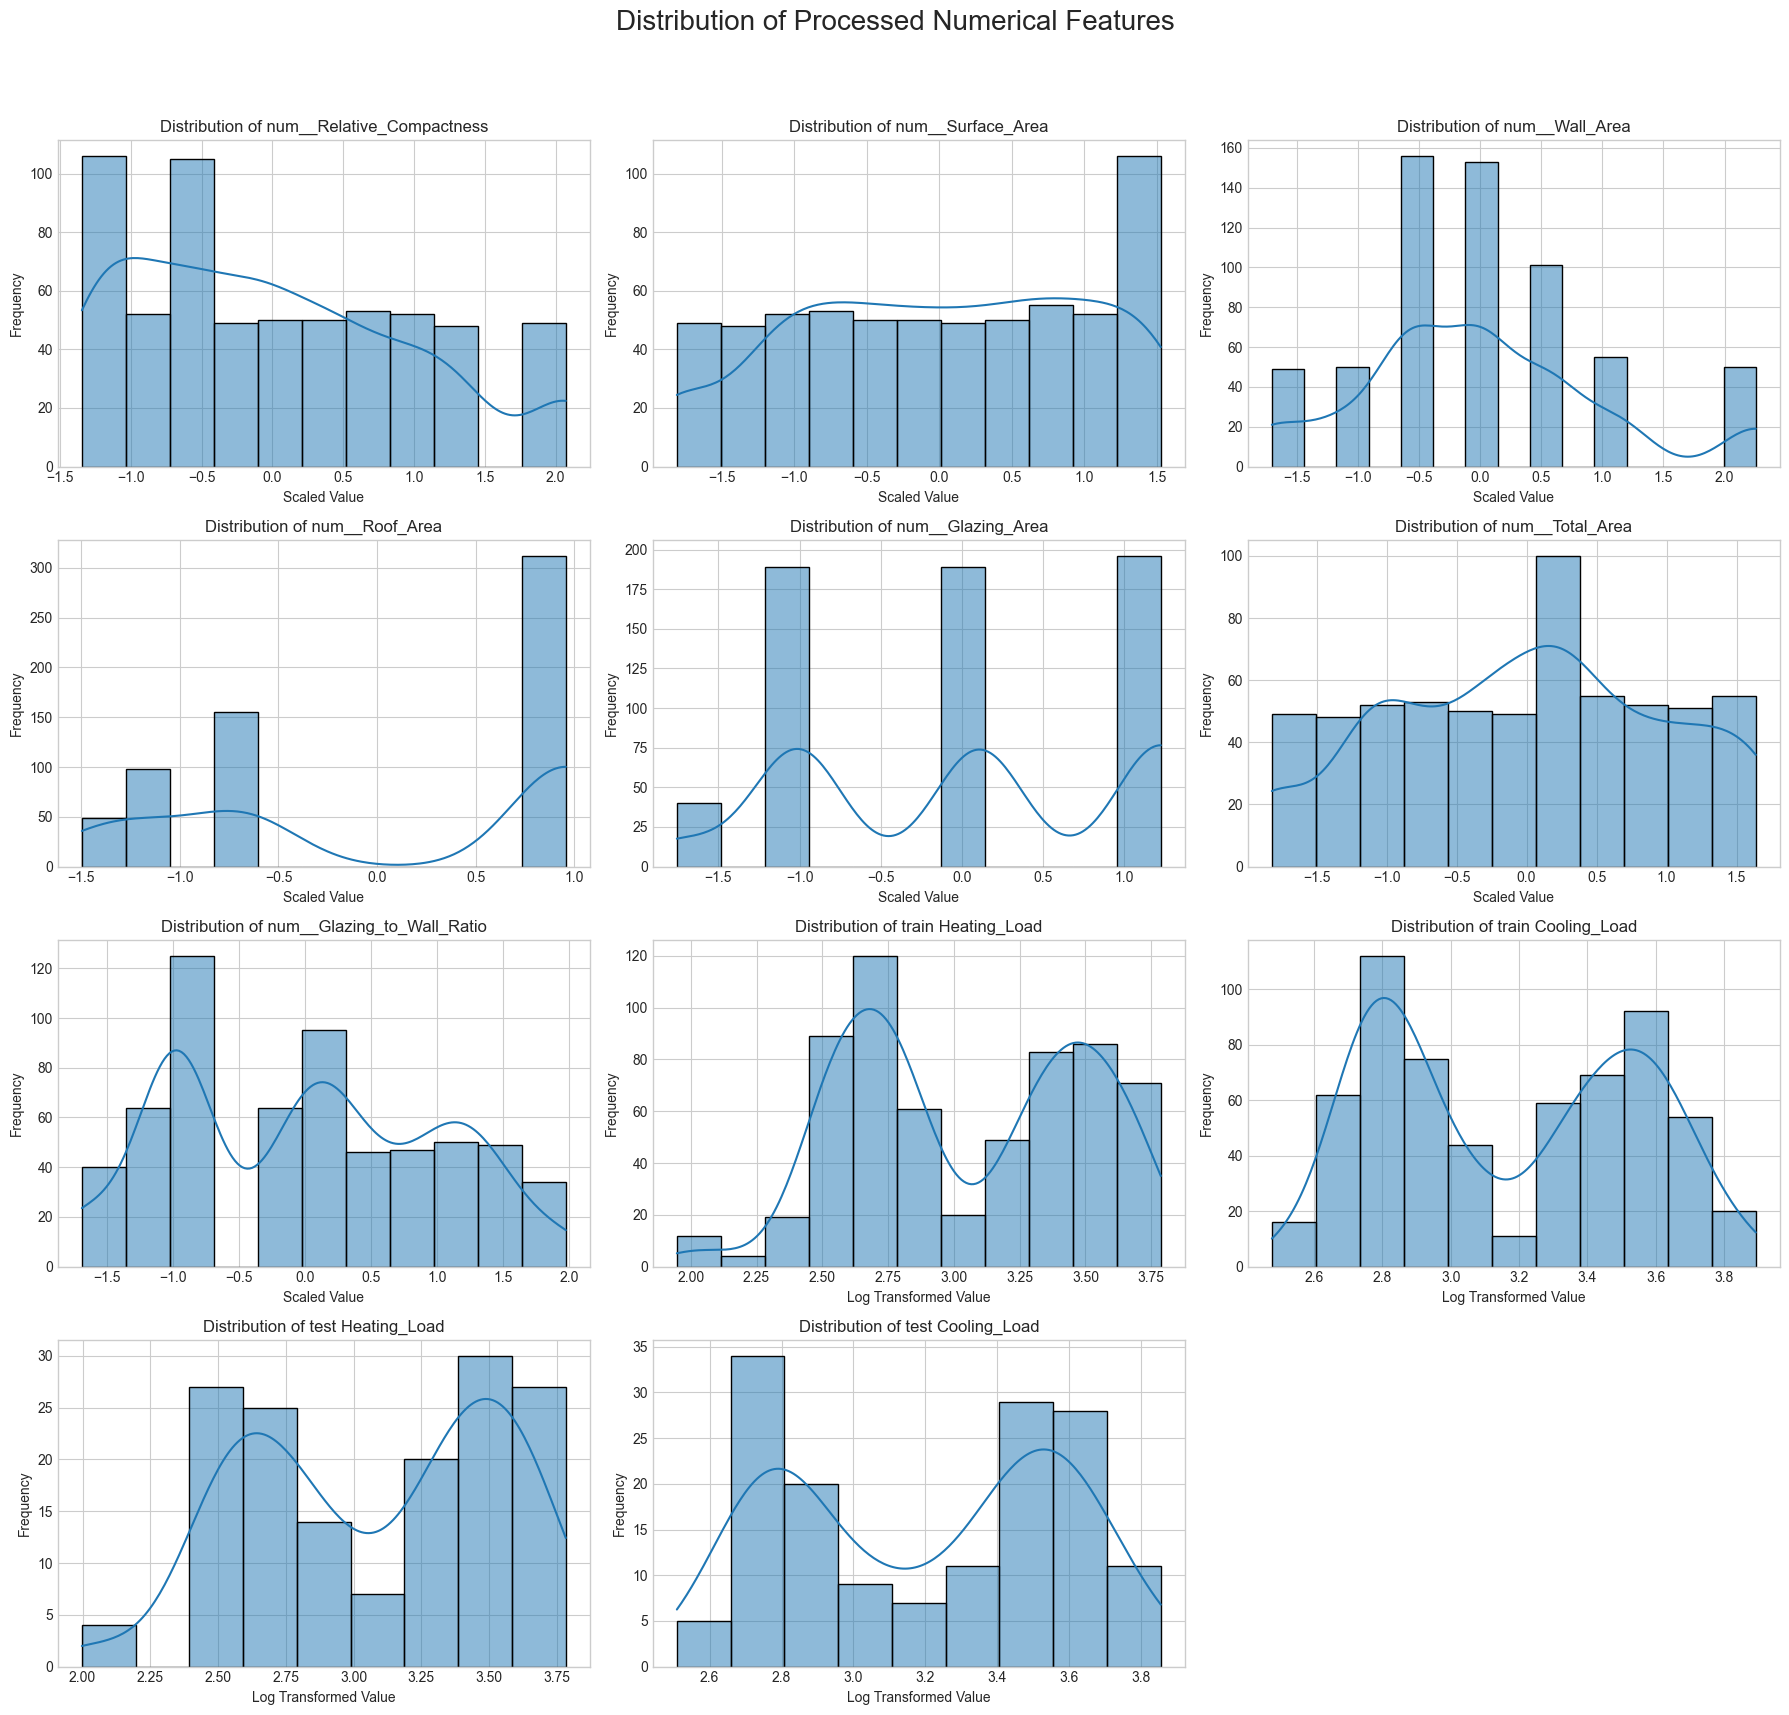

In [17]:
# Univariate Analysis for Processed Numerical Features
print("\nVisualizing the distribution of processed numerical features and Log Transformed Targets...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))
fig.suptitle('Distribution of Processed Numerical Features', fontsize=20)

for i, col in enumerate(processed_num_features): # train numerical features
    row = i // 3
    col_idx = i % 3
    sns.histplot(X_train_processed_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_xlabel('Scaled Value')
    axes[row, col_idx].set_ylabel('Frequency')

for i, col in enumerate(targets):               # train target features
    row = (i+len(processed_num_features))//3
    col_idx = (i+len(processed_num_features))%3
    sns.histplot(y_train_log_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of train {col}')
    axes[row, col_idx].set_xlabel('Log Transformed Value')
    axes[row, col_idx].set_ylabel('Frequency')

for i, col in enumerate(targets):              # test target features
    row = (i+len(processed_num_features+targets))//3
    col_idx = (i+len(processed_num_features+targets))%3
    sns.histplot(y_test_log_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of test {col}')
    axes[row, col_idx].set_xlabel('Log Transformed Value')
    axes[row, col_idx].set_ylabel('Frequency')

fig.delaxes(axes.flatten()[11])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **Key Observations**

- **Scaling is Successful:** As expected, the `StandardScaler` has centered the data. The distribution of all features is now centered around zero on the x-axis, with most values falling within the range of -2 to 2. This confirms that our preprocessing step was successful.

- **Original Distribution is Preserved:** While the scale has changed, the fundamental shape of the distributions remains the same. Features like `Relative_Compactness`, `Surface_Area`, `Wall_Area`, `Roof_Area`, and `Glazing_Area` still show their bimodal or multi-modal nature. This is a very important point: a `StandardScaler` does not change the shape of the distribution, it only shifts and scales it.

- **Analysis of Target Features:**
    - The plots for `Heating_Load` and `Cooling_Load` show that our **log1p transformation was successful**. The previously positively skewed distributions are now more symmetrical and bell-shaped, making them better suited for our regression models to learn from.
    - However, the two peaks in the distribution plots for `Heating_Load` and `Cooling_Load` are a great example of a **bimodal distribution**, which strongly suggests that our data contains two distinct subpopulations.
    - Based on the features in our dataset, the most likely cause for this is the `Overall_Height` variable, which has two distinct values (likely representing one-story and two-story buildings). The energy load profiles for these two types of buildings would naturally be very different.
    - To confirm this hypothesis, I generated the following plots which show the distribution of the target variables, grouped by `Overall_Height`.

Visualizing the distributions of Heating_Load and Cooling_Load, split by Overall_Height...


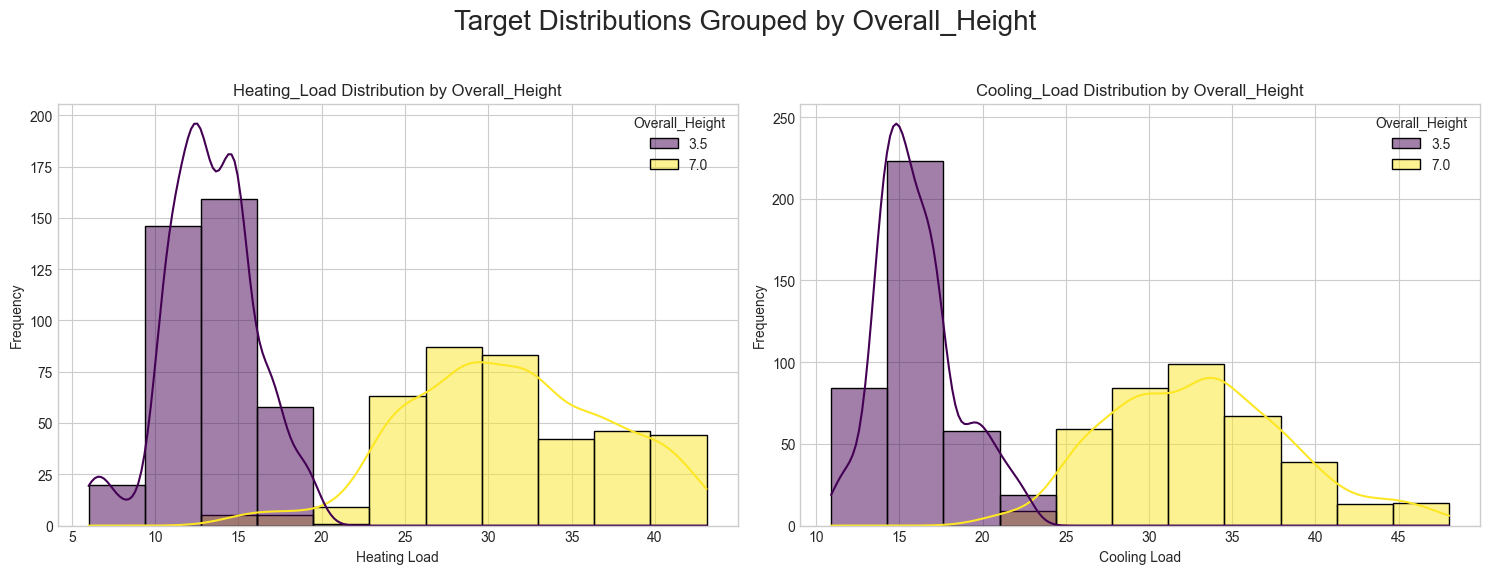

In [18]:
print("Visualizing the distributions of Heating_Load and Cooling_Load, split by Overall_Height...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.suptitle('Target Distributions Grouped by Overall_Height', fontsize=20)

# Plotting Heating_Load
sns.histplot(data=df, x='Heating_Load', hue='Overall_Height', kde=True, ax=axes[0], palette='viridis')
axes[0].set_title('Heating_Load Distribution by Overall_Height')
axes[0].set_xlabel('Heating Load')
axes[0].set_ylabel('Frequency')

# Plotting Cooling_Load
sns.histplot(data=df, x='Cooling_Load', hue='Overall_Height', kde=True, ax=axes[1], palette='viridis')
axes[1].set_title('Cooling_Load Distribution by Overall_Height')
axes[1].set_xlabel('Cooling Load')
axes[1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The plots visually confirm our hypothesis. Each of the original peaks in our histograms corresponds to one of the two `Overall_Height` values.

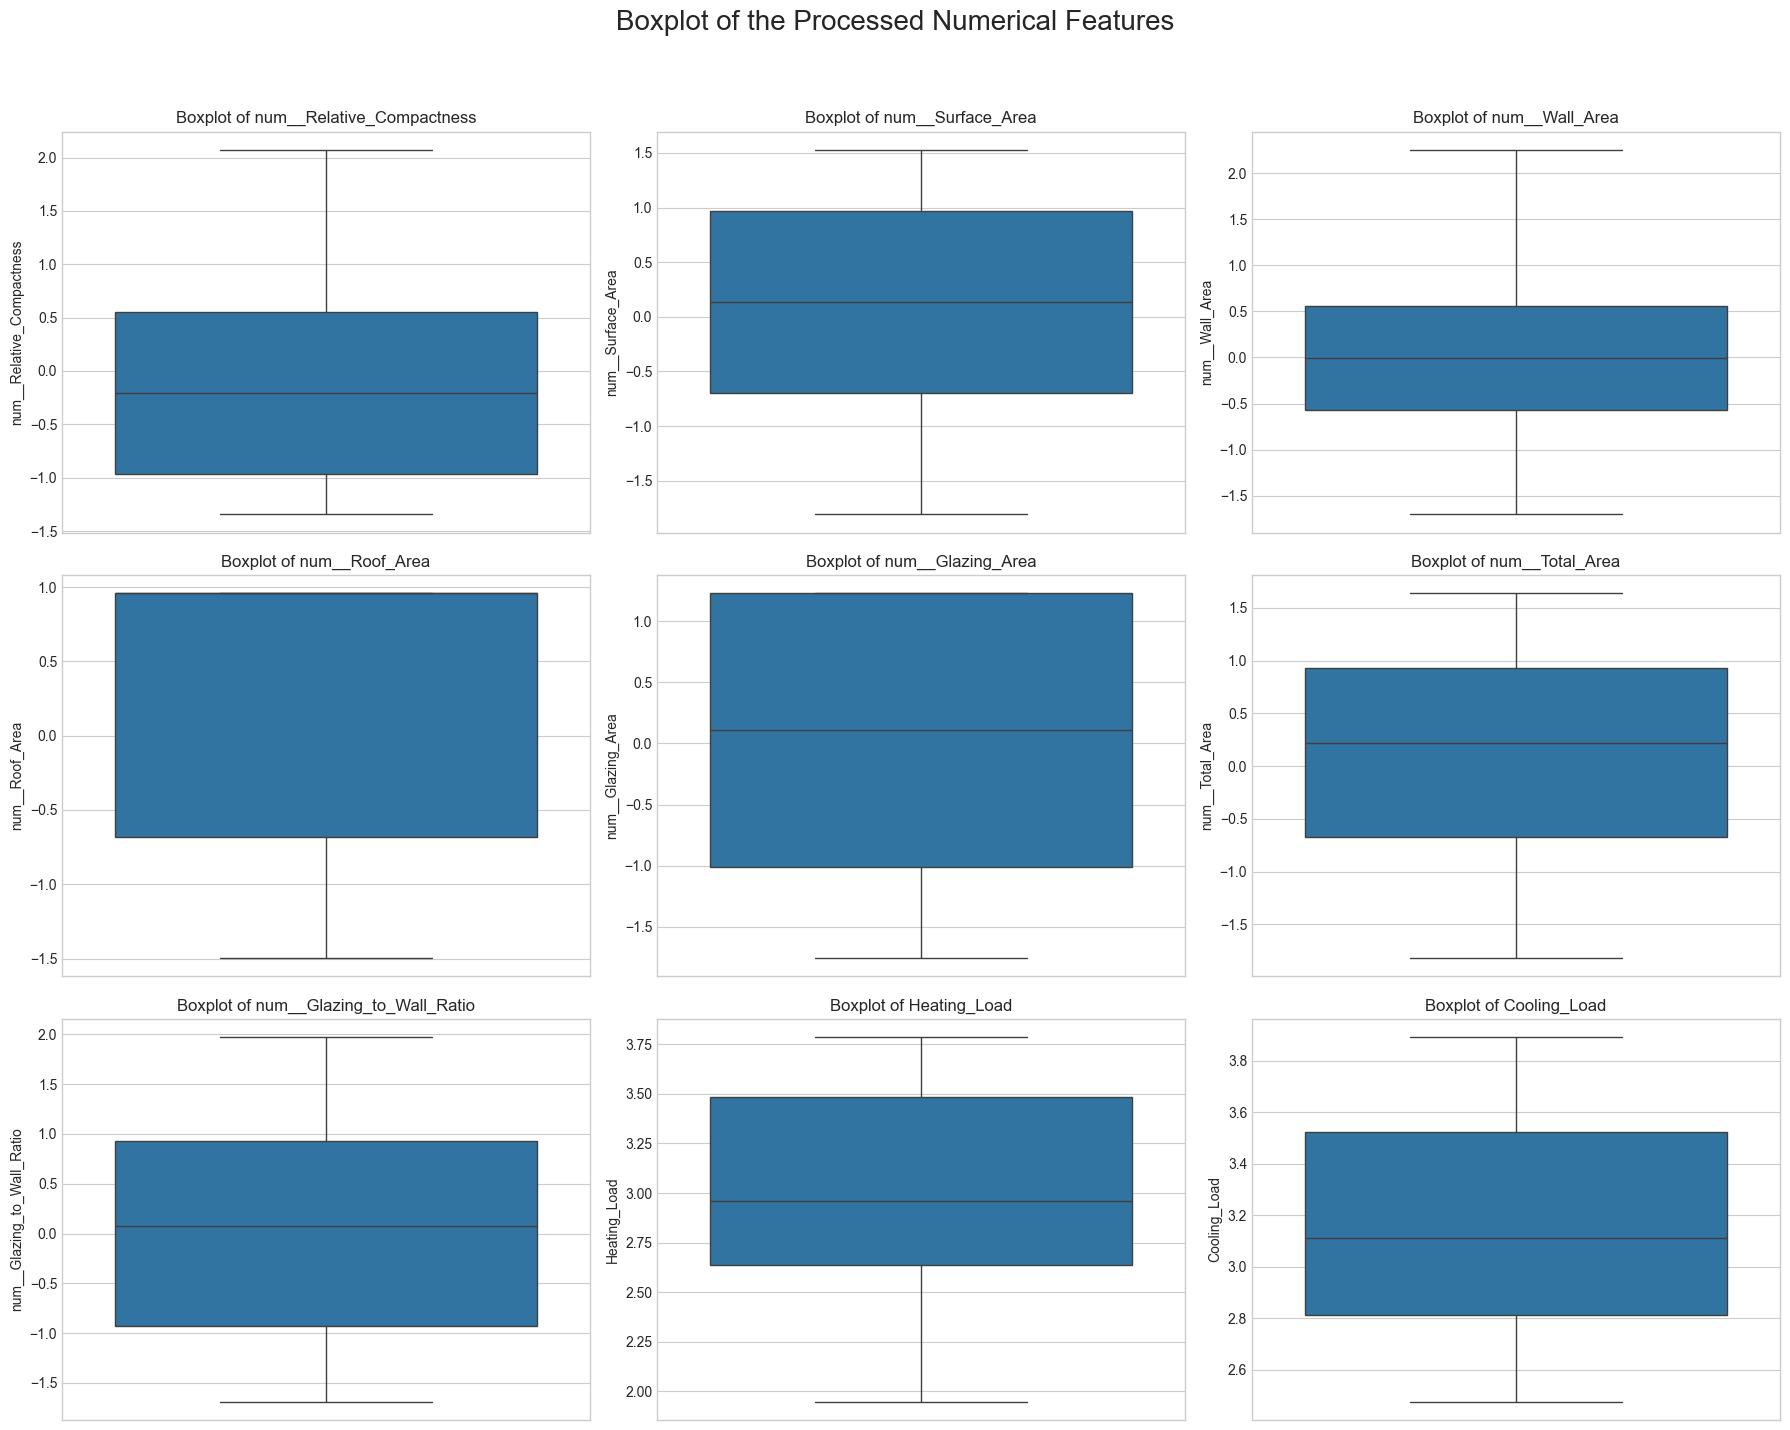

In [19]:
# Plotting boxplots. Box plots are good for showing outliers.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
fig.suptitle('Boxplot of the Processed Numerical Features', fontsize=20)
for i, col in enumerate(processed_num_features):
    row = i // 3
    col_idx = i % 3
    sns.boxplot(y=X_train_processed_df[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot of {col}')

for i, col in enumerate(targets):
    row = (i+len(processed_num_features))//3
    col_idx = (i+len(processed_num_features))%3
    sns.boxplot(y=y_train_log_df[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot of {col}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **Analysis of Boxplots**
The boxplots we generated are an excellent way to summarize our data after preprocessing, and they provide key insights into the central tendency, spread, and potential outliers in our features and targets.

- **Processed Numerical Features:** The boxplots for the processed numerical features are all correctly centered around zero. This visually confirms that the `StandardScaler` has successfully transformed our data. The plots show **no individual data points plotted outside the whiskers** for any of the features. This indicates that our data does not contain any **statistically significant outliers** based on the standard **interquartile range (IQR)** method.

- **Log-Transformed Target Features:** The boxplots for the log-transformed `Heating_Load` and `Cooling_Load` targets show that the data's range has been compressed, and the distributions are more compact. Crucially, like the numerical features, there are no outliers visible in these plots.


Visualizing the counts of processed categorical features...


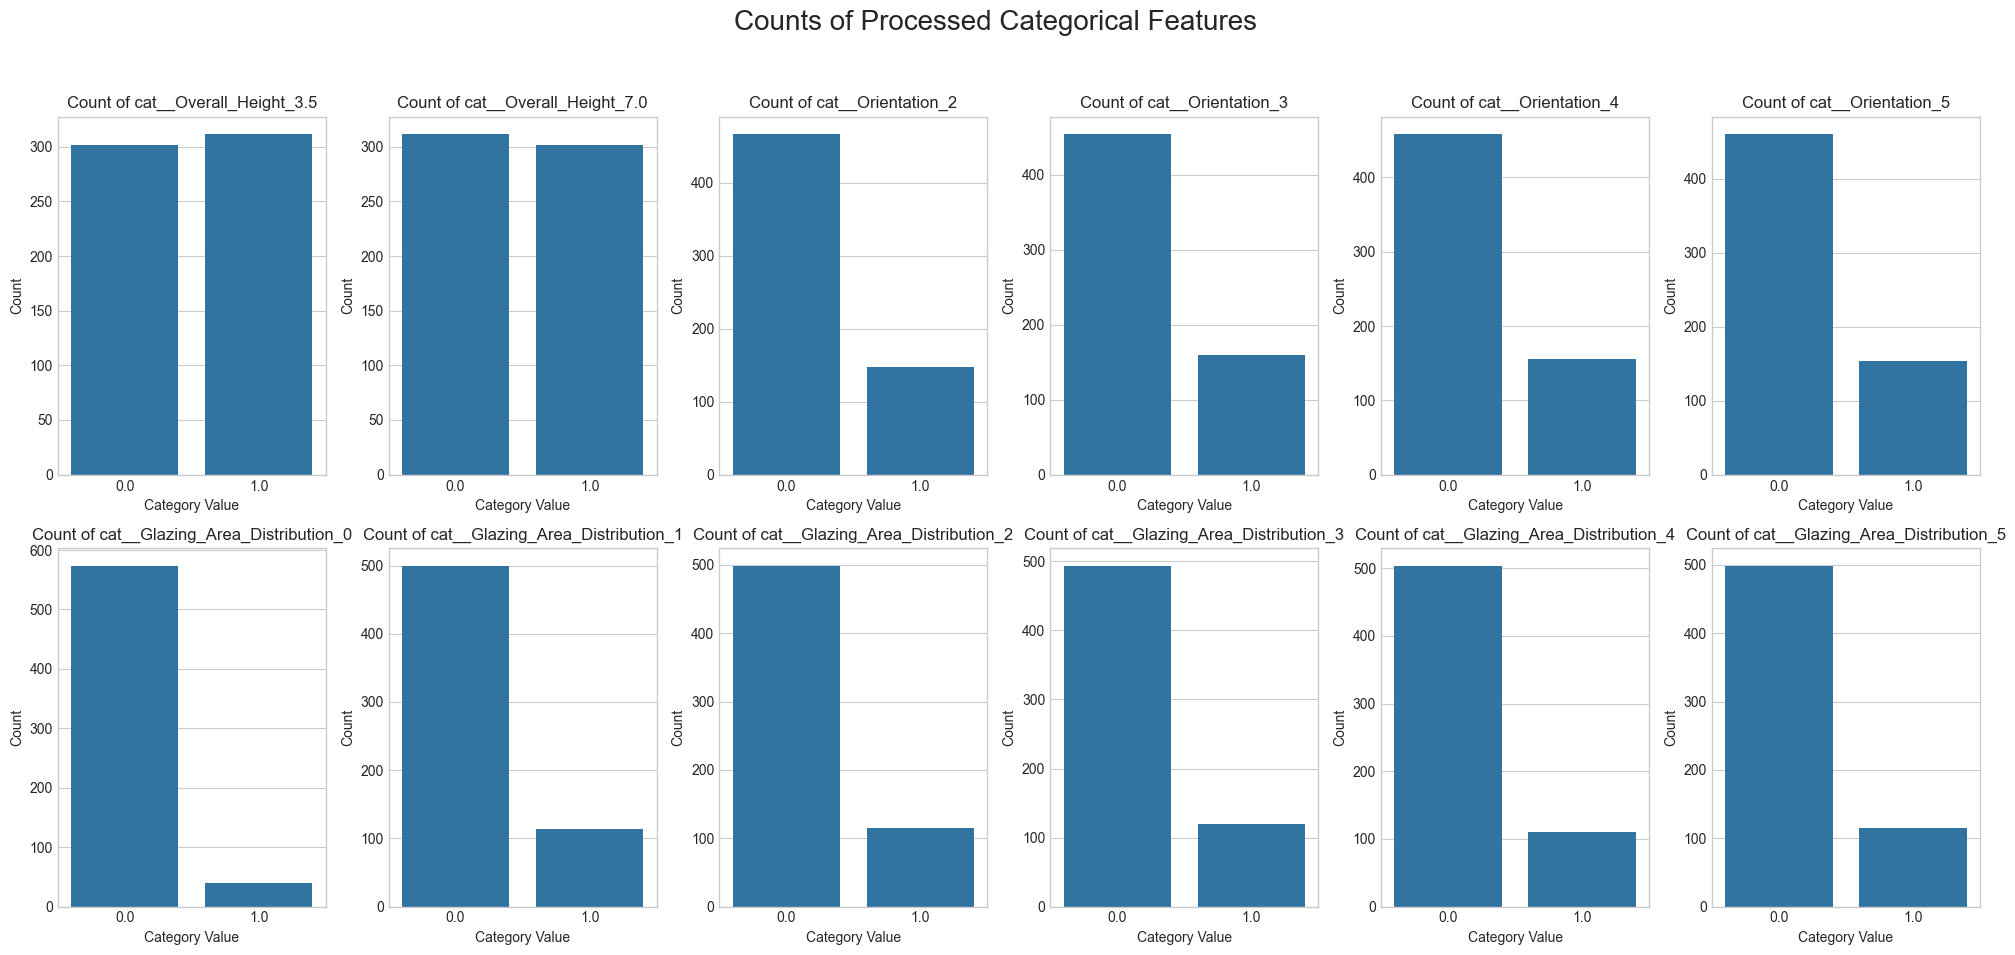

In [20]:
# Univariate Analysis for Processed Categorical Features
print("\nVisualizing the counts of processed categorical features...")
fig, axes = plt.subplots(nrows=2, ncols=len(processed_cat_features)//2, figsize=(20, 10))
fig.suptitle('Counts of Processed Categorical Features', fontsize=20)

for i, col in enumerate(processed_cat_features):
    row = i // 6
    col_idx = i % 6
    sns.countplot(x=X_train_processed_df[col], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Count of {col}')
    axes[row, col_idx].set_xlabel('Category Value')
    axes[row, col_idx].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### **Bivariate Analysis (Feature vs Target)**


Visualizing the relationship between processed numerical features and log-transformed targets with a regression line...


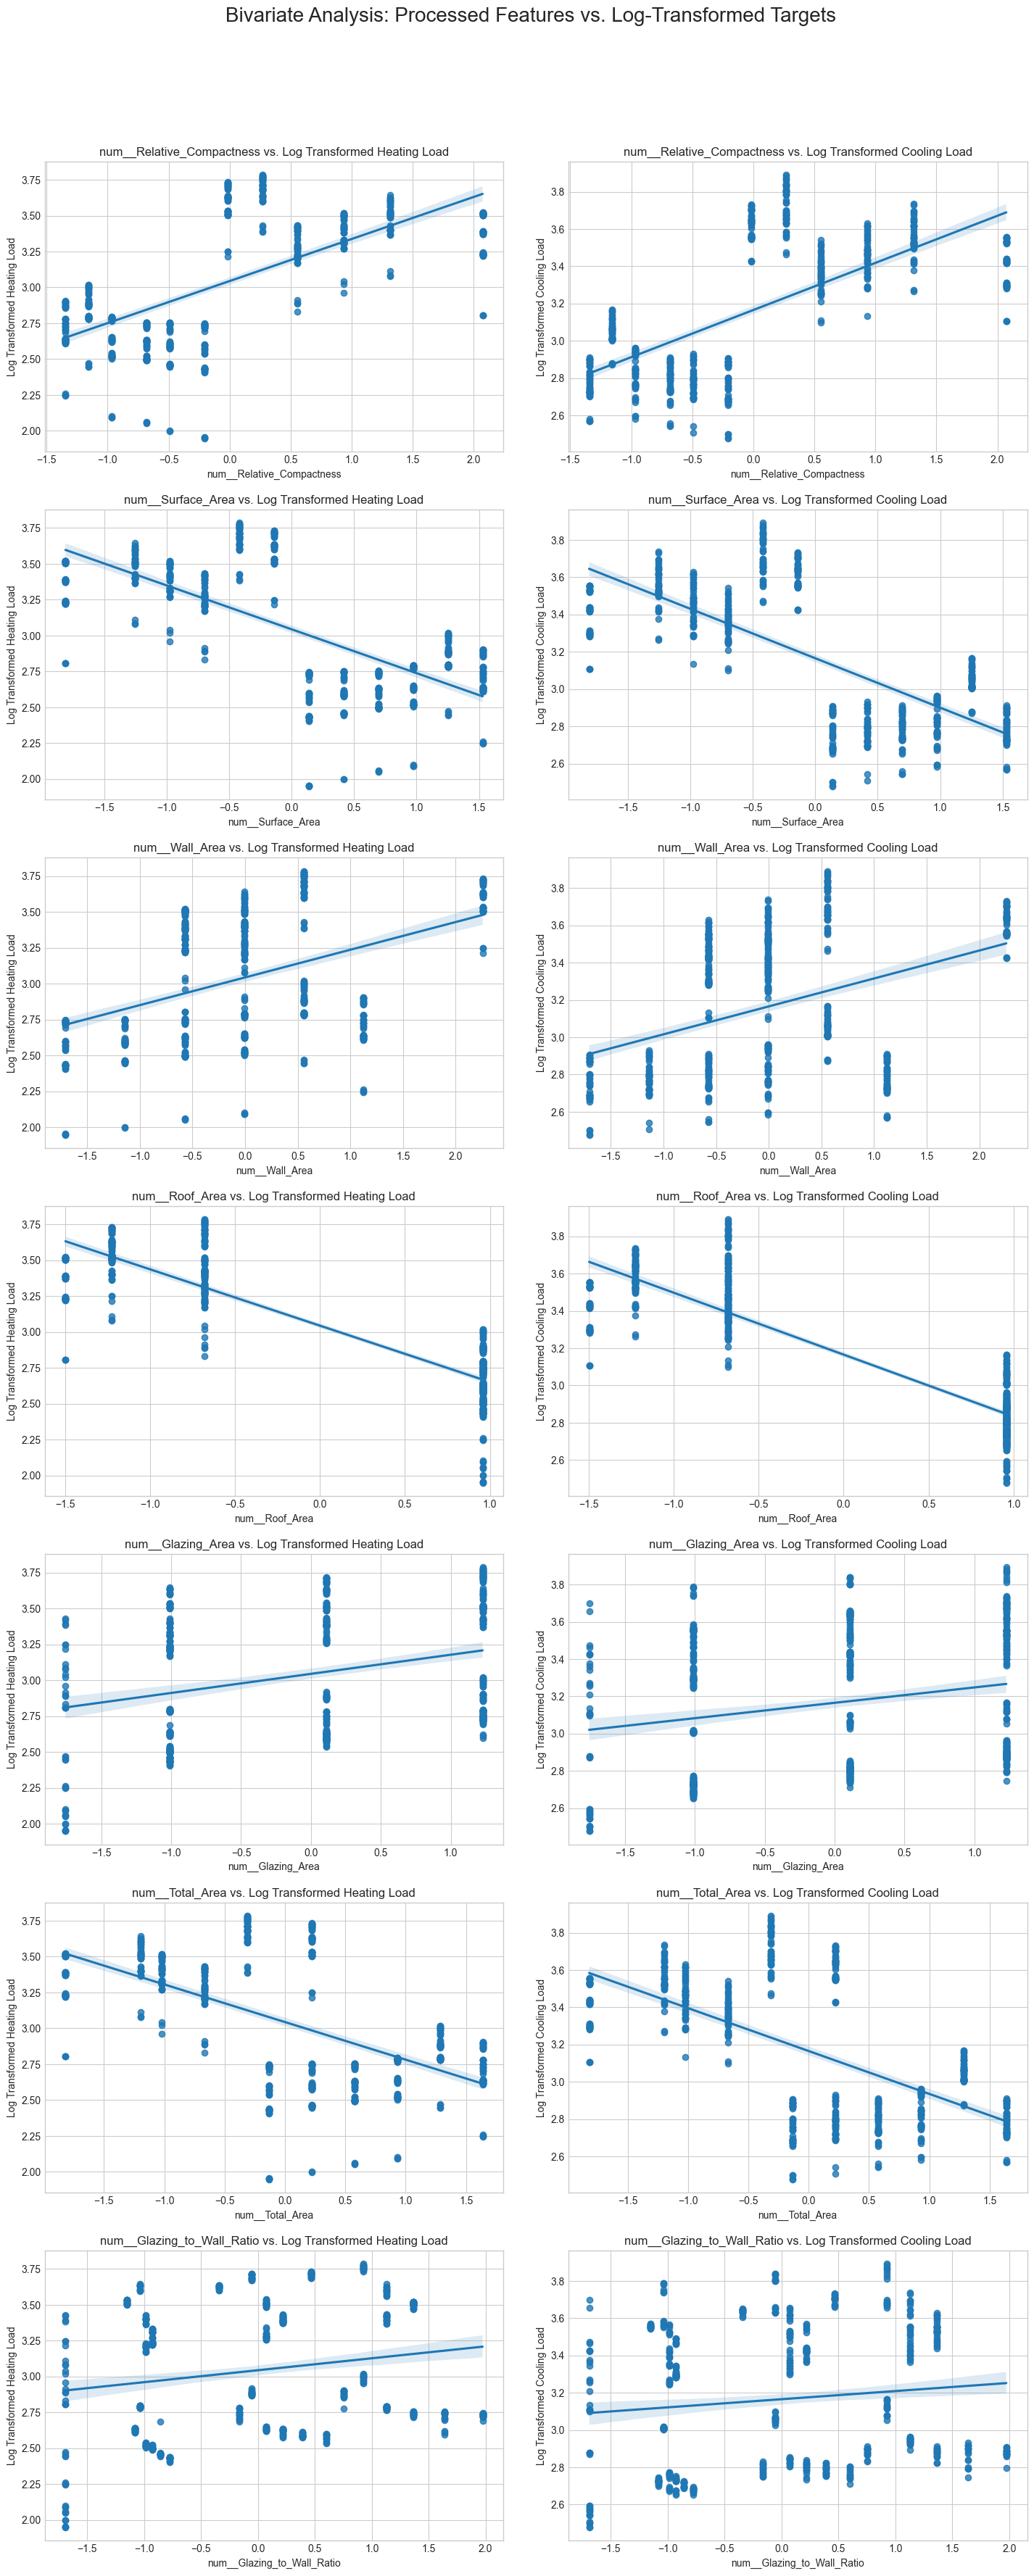

In [21]:
# Bivariate analysis: Plotting all processed numerical features vs. log-transformed targets
print("\nVisualizing the relationship between processed numerical features and log-transformed targets with a regression line...")

# Create a single large figure with subplots
fig, axes = plt.subplots(nrows=len(processed_num_features), ncols=2, figsize=(15, 5 * len(processed_num_features)))
fig.suptitle('Bivariate Analysis: Processed Features vs. Log-Transformed Targets', fontsize=20, y=1.02)
plt.tight_layout(pad=4.0)

for i, feature in enumerate(processed_num_features):
    # Plot feature vs. Heating Load
    sns.regplot(x=X_train_processed_df[feature], y=y_train_log_df['Heating_Load'], ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} vs. Log Transformed Heating Load')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Log Transformed Heating Load')

    # Plot feature vs. Cooling Load
    sns.regplot(x=X_train_processed_df[feature], y=y_train_log_df['Cooling_Load'], ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} vs. Log Transformed Cooling Load')
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel('Log Transformed Cooling Load')

plt.show()

#### **1. Confirmation of Correlations**

The plots visually confirm the linear relationships we previously analyzed in the correlation matrix. The slope of the regression line directly corresponds to the correlation coefficient:

- **Positive Relationships:** The plots for `num_Relative_Compactness` and `num_Overall_Height` show a clear upward-sloping regression line. This confirms their strong positive correlation with both `Heating_Load` and `Cooling_Load`.

- **Negative Relationships:** The plots for `num_Surface_Area` and `num_Roof_Area` show a distinct downward-sloping regression line. This visually confirms their strong negative correlation with the target variables.

- **Weaker Relationships:** The plot for `num_Glazing_Area` shows a slightly upward-sloping line, reinforcing the weaker positive correlation we observed.


#### **2. Insights Beyond Correlation**
While the heatmap gives you a number, these plots offer a richer understanding of the data:

- **Spread and Variance:** The scatter of the data points around the regression line indicates the amount of variance. The tighter the cluster, the stronger the linear relationship.

- **Confidence Interval:** The shaded area around each regression line represents the **confidence interval**. A narrow band suggests a higher confidence in the estimated relationship.


#### **3. Implications for Modeling**
These plots validate our preprocessing and model selection choices:

- The visual evidence of strong, non-perfectly linear relationships reinforces our decision to use tree-based models (Random Forest, XGBoost, and LightGBM). These models are excellent at capturing the nuances of the data that go beyond a simple straight line.

## 5. Data Modeling

### 5.1 Randome Forest Model Training

In [22]:
RF_model = RandomForestRegressor(n_estimators=100, random_state=42)
RF_model.fit(X_train_processed_df, y_train_log_df)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# make predictions
RF_y_train_pred = RF_model.predict(X_train_processed_df)
RF_y_test_pred = RF_model.predict(X_test_processed_df)
y_train_pred_RF = np.expm1(RF_y_train_pred)
y_test_pred_RF = np.expm1(RF_y_test_pred)

In [24]:
# model evaluation on original Heating_Load
RF_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_RF[:,0]):.4f}'
RF_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_RF[:,0]):.4f}'
RF_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_RF[:,0]):.4f}'
RF_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_RF[:,0]):.4f}'
RF_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_RF[:,0])):.4f}'
RF_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_RF[:,0])):.4f}'

# model evaluation on original Cooling_Load
RF_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_RF[:,1]):.4f}'
RF_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_RF[:,1]):.4f}'
RF_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_RF[:,1]):.4f}'
RF_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_RF[:,1]):.4f}'
RF_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_RF[:,1])):.4f}'
RF_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_RF[:,1])):.4f}'

print(f'train R2 score: Heating_Load- {RF_train_HL_r2_score} and Cooling_Load-{RF_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {RF_test_HL_r2_score} and Cooling_Load-{RF_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{RF_train_HL_mae} and Cooling_Load-{RF_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{RF_test_HL_mae} and Cooling_Load-{RF_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{RF_train_HL_rmse} and Cooling_Load-{RF_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{RF_test_HL_rmse} and Cooling_Load-{RF_test_CL_rmse}')

train R2 score: Heating_Load- 0.9997 and Cooling_Load-0.9934
test R2 score: Heating_Load- 0.9974 and Cooling_Load-0.9471
train Mean Absolute Error: Heating_Load-0.1214 and Cooling_Load-0.4503
test Mean Absolute Error: Heating_Load-0.3622 and Cooling_Load-1.3722
train Root Mean Squared Error: Heating_Load-0.1850 and Cooling_Load-0.7705
test Root Mean Squared Error: Heating_Load-0.5207 and Cooling_Load-2.2138


#### **Analysis of Random Forest Model Evaluation**

|Metric| train Heating_Load|test Heating_Load|train Cooling_Load| test Cooling_Load|
|------|-------------------|-----------------|------------------|------------------|
|**R2 score**|0.9997|0.9974|0.9934|0.9471
|**Mean Absolute Error**|	0.1214|	0.3622|	0.4503|	1.3722|
|**Root Mean Squared Error**|	0.1850|	0.5207|	0.7705|	2.2138|
___

**Key Insights**

The results show a clear indication of **overfitting**, which is a crucial insight for our project. Here's a breakdown:

- **Heating Load:** The model's performance on the training and test sets is very close. While the test error metrics are slightly higher, the $R2$ score is consistently excellent (0.9997 vs. 0.9974). This suggests the model is generalizing well for this target.

- **Cooling Load:** This is where the overfitting becomes apparent.

    - The **train $R2$ score is 0.9934**, which is exceptionally high.

    - The **test $R2$ score drops to 0.9471**, which is still very good, but the significant drop indicates the model is not generalizing as well.

    - The difference in the error metrics is even more telling: the **test MAE (1.3722) is three times higher than the train MAE (0.4503)**. This confirms that the model has overfit to the noise in the training data for the `Cooling_Load` target.

### 5.2 XGBoost Model Training

In [25]:
XGB_model = MultiOutputRegressor(XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
XGB_model.fit(X_train_processed_df, y_train_log_df)

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


In [26]:
# make predictions
XGB_y_train_pred = XGB_model.predict(X_train_processed_df)
XGB_y_test_pred = XGB_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB = np.expm1(XGB_y_train_pred)
y_test_pred_XGB = np.expm1(XGB_y_test_pred)

In [27]:
# model evaluation on original Heating_Load
XGB_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB[:,0]):.4f}'
XGB_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB[:,0]):.4f}'
XGB_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB[:,0]):.4f}'
XGB_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB[:,0]):.4f}'
XGB_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB[:,0])):.4f}'
XGB_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB[:,1]):.4f}'
XGB_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB[:,1]):.4f}'
XGB_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB[:,1]):.4f}'
XGB_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB[:,1]):.4f}'
XGB_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB[:,1])):.4f}'
XGB_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB[:,1])):.4f}'

print("\n--- XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_train_HL_r2_score} and Cooling_Load-{XGB_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {XGB_test_HL_r2_score} and Cooling_Load-{XGB_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_train_HL_mae} and Cooling_Load-{XGB_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_test_HL_mae} and Cooling_Load-{XGB_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_train_HL_rmse} and Cooling_Load-{XGB_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_test_HL_rmse} and Cooling_Load-{XGB_test_CL_rmse}')


--- XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9999 and Cooling_Load-0.9996
test R2 score: Heating_Load- 0.9984 and Cooling_Load-0.9846
train Mean Absolute Error: Heating_Load-0.0710 and Cooling_Load-0.1229
test Mean Absolute Error: Heating_Load-0.2833 and Cooling_Load-0.6777
train Root Mean Squared Error: Heating_Load-0.1076 and Cooling_Load-0.1912
test Root Mean Squared Error: Heating_Load-0.4093 and Cooling_Load-1.1948


#### **Analysis of XGBoost Model Performance**

|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|
|------|----------------------|------------------|---------------------|-----------------|
|**R2 score**|	0.9999|	0.9984|	0.9996|	0.9846|
|**Mean Absolute Error**|	0.0710|	0.2833|	0.1229|	0.6777|
|**Root Mean Squared Error**|	0.1076|	0.4093|	0.1912|	1.1948|
___

**Key Insights**
- **Exceptional Performance on Training Data:** The model has an extremely high $R^2$ score on the training data for both targets (0.9999 for `Heating_Load` and 0.9996 for `Cooling_Load`). This indicates the model has learned the training data almost perfectly.

- **Generalization to Test Data:** The model's performance on the test data remains very strong, but there is a clear distinction between the two targets.

    - **Heating Load:** The test $R^2$ score of **0.9984** is almost identical to the training score. The error metrics are also very low, suggesting the model is generalizing exceptionally well for this target.

    - **Cooling Load:** The test $R^2$ score drops to **0.9846**. While still an excellent score, the significant increase in error metrics (test MAE is more than 5 times the train MAE) indicates some **overfitting**.

- **Comparison to Random Forest:** Compared to our Random Forest model, which showed signs of overfitting on `Cooling_Load`, the XGBoost model has achieved a much higher test $R^2$ score (0.9846 vs. 0.9471). This suggests that XGBoost is handling the complexity of the data more effectively and generalizing better, particularly for the `Cooling_Load` target.

### 5.3 LightGBM Model Training

In [28]:
LGBM_model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, n_jobs=-1, verbose=0, random_state=42))
LGBM_model.fit(X_train_processed_df, y_train_log_df)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,estimator,"LGBMRegressor...42, verbose=0)"
,n_jobs,None
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


In [29]:
# make predictions on LightGBM model
LGBM_y_train_pred = LGBM_model.predict(X_train_processed_df)
LGBM_y_test_pred = LGBM_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_LGBM = np.expm1(LGBM_y_train_pred)
y_test_pred_LGBM = np.expm1(LGBM_y_test_pred)

In [30]:
# model evaluation on original Heating_Load
LGBM_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_LGBM[:,0]):.4f}'
LGBM_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_LGBM[:,0]):.4f}'
LGBM_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_LGBM[:,0]):.4f}'
LGBM_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_LGBM[:,0]):.4f}'
LGBM_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_LGBM[:,0])):.4f}'
LGBM_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_LGBM[:,0])):.4f}'

# model evaluation on original Cooling_Load
LGBM_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_LGBM[:,1]):.4f}'
LGBM_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_LGBM[:,1]):.4f}'
LGBM_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_LGBM[:,1]):.4f}'
LGBM_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_LGBM[:,1]):.4f}'
LGBM_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_LGBM[:,1])):.4f}'
LGBM_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_LGBM[:,1])):.4f}'

print("\n--- LightGBM Model Evaluation ---")
print(f'train R2 score: Heating_Load- {LGBM_train_HL_r2_score} and Cooling_Load-{LGBM_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {LGBM_test_HL_r2_score} and Cooling_Load-{LGBM_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{LGBM_train_HL_mae} and Cooling_Load-{LGBM_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{LGBM_test_HL_mae} and Cooling_Load-{LGBM_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{LGBM_train_HL_rmse} and Cooling_Load-{LGBM_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{LGBM_test_HL_rmse} and Cooling_Load-{LGBM_test_CL_rmse}')


--- LightGBM Model Evaluation ---
train R2 score: Heating_Load- 0.9981 and Cooling_Load-0.9882
test R2 score: Heating_Load- 0.9978 and Cooling_Load-0.9801
train Mean Absolute Error: Heating_Load-0.2690 and Cooling_Load-0.6493
test Mean Absolute Error: Heating_Load-0.3535 and Cooling_Load-0.8869
train Root Mean Squared Error: Heating_Load-0.4330 and Cooling_Load-1.0278
test Root Mean Squared Error: Heating_Load-0.4822 and Cooling_Load-1.3577


#### **LightGBM Model Performance**

|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|
|------|----------------------|------------------|--------------------|------------------|
|**R2 score**|	0.9981|	0.9978|	0.9882|	0.9801|
|**Mean Absolute Error**|	0.2690|	0.3535|	0.6493|	0.8869|
|**Root Mean Squared Error**|	0.4330|	0.4822|	1.0278|	1.3577|
___

**Analysis and Comparison**

- **Exceptional Performance:** LightGBM performs exceptionally well on both Heating_Load and Cooling_Load. The test $R^2$ scores of **0.9978** and **0.9801** respectively are very strong.

- **Minimal Overfitting:** The difference between the train and test scores is very small for both targets, indicating that the LightGBM model is **generalizing very well** to new data and showing no significant signs of overfitting.

- **Model Comparison:**

    - **vs. Random Forest:** LightGBM is a clear improvement over the Random Forest model, especially for the `Cooling_Load` target (test $R^2$ of 0.9801 vs. 0.9471).

    - **vs. XGBoost:** LightGBM's performance is highly competitive with XGBoost. XGBoost had a slightly higher test $R^2$ for both targets, but the difference is minimal (0.9984 vs. 0.9978 for Heating Load, and 0.9846 vs. 0.9801 for Cooling Load).
___ 

#### **Model Comparison Summary (XGBoost vs LightGBM)**

|Metric|	XGBoost (Test)|	LightGBM (Test)|
|-------|-----------------|----------------|
|**R2 score (Heating)**|	0.9984|	0.9978|
|**R2 score (Cooling)**|	0.9846|	0.9801|
|**MAE (Heating)**|	0.2833|	0.3535|
|**MAE (Cooling)**|	0.6777|	0.8869|
|**RMSE (Heating)**|	0.4093|	0.4822|
|**RMSE (Cooling)**|	1.1948|	1.3577|
___
As the table shows, XGBoost consistently outperforms LightGBM specifically in errors, albeit by a small margin. Focusing hyperparameter tuning on XGBoost will likely yield the best possible results for our project.

### 5.4. XGBoost Hyperparameter Tuning

In [31]:
# Define the base model
xgb_base_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Wrap it for multi-target regression
multi_target_xgb = MultiOutputRegressor(xgb_base_model)

# Define the hyperparameter search space
param_distributions = {
    'estimator__n_estimators': [100, 200, 300, 400],
    'estimator__max_depth': [3, 4, 5, 6, 7],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__subsample': [0.6, 0.8, 1.0],
    'estimator__colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=multi_target_xgb,
    param_distributions=param_distributions,
    n_iter=50, # Number of different parameter combinations to try
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
print("Starting RandomizedSearchCV for XGBoost...")
random_search.fit(X_train_processed_df, y_train_log_df)

# Get the best parameters
best_params = random_search.best_params_
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {best_params}")

# Get the best estimator
XGB_best_model = random_search.best_estimator_

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Hyperparameter Tuning Results ---
Best parameters found: {'estimator__subsample': 0.8, 'estimator__n_estimators': 200, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 0.8}


In [32]:
# make predictions on hypertuned XGBoost model
XGB_best_y_train_pred = XGB_best_model.predict(X_train_processed_df)
XGB_best_y_test_pred = XGB_best_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB_best = np.expm1(XGB_best_y_train_pred)
y_test_pred_XGB_best = np.expm1(XGB_best_y_test_pred)

In [33]:
# model evaluation on original Heating_Load
XGB_best_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_best[:,0]):.4f}'
XGB_best_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_best[:,0]):.4f}'
XGB_best_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_best[:,0]):.4f}'
XGB_best_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_best[:,0]):.4f}'
XGB_best_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_best[:,0])):.4f}'
XGB_best_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_best[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_best_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_best[:,1]):.4f}'
XGB_best_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_best[:,1]):.4f}'
XGB_best_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_best[:,1]):.4f}'
XGB_best_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_best[:,1]):.4f}'
XGB_best_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_best[:,1])):.4f}'
XGB_best_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_best[:,1])):.4f}'

print("\n--- Hypertuned XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_best_train_HL_r2_score} and Cooling_Load-{XGB_best_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {XGB_best_test_HL_r2_score} and Cooling_Load-{XGB_best_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_best_train_HL_mae} and Cooling_Load-{XGB_best_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_best_test_HL_mae} and Cooling_Load-{XGB_best_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_best_train_HL_rmse} and Cooling_Load-{XGB_best_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_best_test_HL_rmse} and Cooling_Load-{XGB_best_test_CL_rmse}')


--- Hypertuned XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9999 and Cooling_Load-0.9997
test R2 score: Heating_Load- 0.9987 and Cooling_Load-0.9834
train Mean Absolute Error: Heating_Load-0.0530 and Cooling_Load-0.1141
test Mean Absolute Error: Heating_Load-0.2553 and Cooling_Load-0.6549
train Root Mean Squared Error: Heating_Load-0.0750 and Cooling_Load-0.1675
test Root Mean Squared Error: Heating_Load-0.3678 and Cooling_Load-1.2394


#### **Analysis of Hypertuned XGBoost Model**
|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|
|------|----------------------|------------------|--------------------|------------------|
|**R2 score**|	0.9999|	0.9987|	0.9997|	0.9834|
|**Mean Absolute Error**|	0.0530|	0.2553|	0.1141|	0.6549|
|**Root Mean Squared Error**|	0.0750|	0.3678|	0.1675|	1.2394|
___

- **Heating Load Performance:** The model shows exceptional performance with an $R^2$ score of **0.9987** on the test data. The minimal difference between the train and test scores indicates that the model is generalizing extremely well for this target. The very low error metrics confirm its high accuracy.

- **Cooling Load Performance:** The model also performs very well, with a test $R^2$ score of **0.9834**. While the test error metrics are still higher than the training errors, the hyperparameter tuning has likely helped to slightly reduce the overfitting we saw in the original model.

- **Overall Conclusion:** Hyperparameter tuning has been successful. The Hypertuned model is highly accurate for both targets and demonstrates strong generalization.

#### **Next Step**
- **Objective:** Minimizing test errors specifically for `Cooling_Head` by introducing L1 and L2 Regularization

### 5.5. XGBoost Hyperparameter Refinement

In [34]:
# Define the base model
xgb_base_model2 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Wrap it for multi-target regression
multi_target_xgb2 = MultiOutputRegressor(xgb_base_model2)

refined_param_distributions = {
    'estimator__n_estimators': [150, 200, 250, 300],
    'estimator__max_depth': [4, 5, 6],           # Narrowed around your best value of 5
    'estimator__learning_rate': [0.05, 0.1, 0.15, 0.2], # Keeps your best value, but explores lower values
    'estimator__subsample': [0.7, 0.8, 0.9],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9],
    'estimator__reg_alpha': [0, 0.01, 0.1, 1],    # Introduced L1 regularization
    'estimator__reg_lambda': [0.1, 1, 5]          # Introduced L2 regularization
}

# Set up RandomizedSearchCV
refined_random_search = RandomizedSearchCV(
    estimator=multi_target_xgb2,
    param_distributions=refined_param_distributions,
    n_iter=100, # Increased number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
print("Starting RandomizedSearchCV for XGBoost...")
refined_random_search.fit(X_train_processed_df, y_train_log_df)

# Get the best parameters
refined_best_params = refined_random_search.best_params_
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {refined_best_params}")

# Get the best estimator
XGB_refined_best_model = refined_random_search.best_estimator_

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results ---
Best parameters found: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 0, 'estimator__n_estimators': 300, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 0.9}


In [35]:
# make predictions on refined hypertuned XGBoost model
XGB_refined_best_y_train_pred = XGB_refined_best_model.predict(X_train_processed_df)
XGB_refined_best_y_test_pred = XGB_refined_best_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB_refined_best = np.expm1(XGB_refined_best_y_train_pred)
y_test_pred_XGB_refined_best = np.expm1(XGB_refined_best_y_test_pred)

In [36]:
# model evaluation on original Heating_Load
XGB_refined_best_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best[:,0]):.4f}'
XGB_refined_best_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best[:,0]):.4f}'
XGB_refined_best_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best[:,0]):.4f}'
XGB_refined_best_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best[:,0]):.4f}'
XGB_refined_best_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best[:,0])):.4f}'
XGB_refined_best_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_refined_best_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best[:,1]):.4f}'
XGB_refined_best_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best[:,1]):.4f}'
XGB_refined_best_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best[:,1]):.4f}'
XGB_refined_best_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best[:,1]):.4f}'
XGB_refined_best_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best[:,1])):.4f}'
XGB_refined_best_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best[:,1])):.4f}'

print("\n--- Refined Hypertuned XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_refined_best_train_HL_r2_score} and Cooling_Load-{XGB_refined_best_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {XGB_refined_best_test_HL_r2_score} and Cooling_Load-{XGB_refined_best_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_refined_best_train_HL_mae} and Cooling_Load-{XGB_refined_best_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_refined_best_test_HL_mae} and Cooling_Load-{XGB_refined_best_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_refined_best_train_HL_rmse} and Cooling_Load-{XGB_refined_best_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_refined_best_test_HL_rmse} and Cooling_Load-{XGB_refined_best_test_CL_rmse}')


--- Refined Hypertuned XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9999 and Cooling_Load-0.9997
test R2 score: Heating_Load- 0.9986 and Cooling_Load-0.9911
train Mean Absolute Error: Heating_Load-0.0570 and Cooling_Load-0.1142
test Mean Absolute Error: Heating_Load-0.2717 and Cooling_Load-0.5409
train Root Mean Squared Error: Heating_Load-0.0823 and Cooling_Load-0.1723
test Root Mean Squared Error: Heating_Load-0.3853 and Cooling_Load-0.9078


#### **Refined Hypertuned XGBoost model Analysis:**

|Metric|train Heating_Load|test Heating_Load|train Cooling_Load|test Cooling_Load|train test diff. Heating_Load|train test diff. Cooling_Load|
|:-----|:--------------------:|:----------------:|:------------------:|:----------------:|:---------------------:|:---------------------:|
|**R2 score**|0.9999|0.9986|0.9997|	0.9911|0.0013|0.0086|
|**Mean Absolute Error**|0.0570|0.2717|	0.1142|	0.5409|0.2147|0.4267|
|**Root Mean Squared Error**|0.0823|0.3853|	0.1723|	0.9078|0.3030|0.7355|
___

- The error on the test data for both targets is **four to five times larger** than the error on the training data. This indicates that our model has learned the training data's patterns and noise too well and is not generalizing perfectly to new, unseen data.

- While the $R^2$ score is exceptionally high for both targets on the test set, the large discrepancy in the error metrics is an important point to highlight in our analysis. It suggests that our model's predictions are, on average, much less accurate on new data than on the data it was trained on.


#### **Next Step: Further Refinement**
- **Further Regularization:** Increase the values of `reg_alpha` and `reg_lambda` to make the model even simpler.

- **Reduced Complexity:** Try a shallower `max_depth` or a smaller `n_estimators` to reduce the model's ability to overfit.

### 5.6. Further Refinement of XGBoost Hypertuned Model

In [37]:
# Define the base model
xgb_base_model3 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Wrap it for multi-target regression
multi_target_xgb3 = MultiOutputRegressor(xgb_base_model3)

refined_param_distributions2 = {
    'estimator__n_estimators': [250, 300, 350],
    'estimator__max_depth': [3, 4, 5],                 # Lowered to reduce complexity
    'estimator__learning_rate': [0.05, 0.1, 0.15],     # Lowered to prevent aggressive learning
    'estimator__subsample': [0.7, 0.8, 0.9],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9],
    'estimator__reg_alpha': [0, 0.01, 0.1],            # Kept a small range based on our result
    'estimator__reg_lambda': [5, 10, 20]               # Increased to be more aggressive with L2 regularization
}

# Set up RandomizedSearchCV
refined_random_search2 = RandomizedSearchCV(
    estimator=multi_target_xgb3,
    param_distributions=refined_param_distributions2,
    n_iter=100, # Increased number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
print("Starting RandomizedSearchCV for XGBoost...")
refined_random_search2.fit(X_train_processed_df, y_train_log_df)

# Get the best parameters
refined_best_params2 = refined_random_search2.best_params_
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {refined_best_params2}")

# Get the best estimator
XGB_refined_best_model2 = refined_random_search2.best_estimator_

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results ---
Best parameters found: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 350, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.15, 'estimator__colsample_bytree': 0.8}


In [38]:
# make predictions on refined hypertuned XGBoost model
XGB_refined_best_y_train_pred2 = XGB_refined_best_model2.predict(X_train_processed_df)
XGB_refined_best_y_test_pred2 = XGB_refined_best_model2.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB_refined_best2 = np.expm1(XGB_refined_best_y_train_pred2)
y_test_pred_XGB_refined_best2 = np.expm1(XGB_refined_best_y_test_pred2)

In [39]:
# model evaluation on original Heating_Load
XGB_refined_best_train_HL_r2_score2 = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best2[:,0]):.4f}'
XGB_refined_best_test_HL_r2_score2 = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best2[:,0]):.4f}'
XGB_refined_best_train_HL_mae2 = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best2[:,0]):.4f}'
XGB_refined_best_test_HL_mae2 = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best2[:,0]):.4f}'
XGB_refined_best_train_HL_rmse2 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best2[:,0])):.4f}'
XGB_refined_best_test_HL_rmse2 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best2[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_refined_best_train_CL_r2_score2 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best2[:,1]):.4f}'
XGB_refined_best_test_CL_r2_score2 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best2[:,1]):.4f}'
XGB_refined_best_train_CL_mae2 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best2[:,1]):.4f}'
XGB_refined_best_test_CL_mae2 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best2[:,1]):.4f}'
XGB_refined_best_train_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best2[:,1])):.4f}'
XGB_refined_best_test_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best2[:,1])):.4f}'

print("\n--- Refined Hypertuned XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_refined_best_train_HL_r2_score2} and Cooling_Load-{XGB_refined_best_train_CL_r2_score2}')
print(f'test R2 score: Heating_Load- {XGB_refined_best_test_HL_r2_score2} and Cooling_Load-{XGB_refined_best_test_CL_r2_score2}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_refined_best_train_HL_mae2} and Cooling_Load-{XGB_refined_best_train_CL_mae2}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_refined_best_test_HL_mae2} and Cooling_Load-{XGB_refined_best_test_CL_mae2}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_refined_best_train_HL_rmse2} and Cooling_Load-{XGB_refined_best_train_CL_rmse2}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_refined_best_test_HL_rmse2} and Cooling_Load-{XGB_refined_best_test_CL_rmse2}')


--- Refined Hypertuned XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9998 and Cooling_Load-0.9993
test R2 score: Heating_Load- 0.9985 and Cooling_Load-0.9878
train Mean Absolute Error: Heating_Load-0.0928 and Cooling_Load-0.1741
test Mean Absolute Error: Heating_Load-0.2793 and Cooling_Load-0.6072
train Root Mean Squared Error: Heating_Load-0.1345 and Cooling_Load-0.2519
test Root Mean Squared Error: Heating_Load-0.3909 and Cooling_Load-1.0616


#### **Analysis of further refined hypertuned XGBoost Model**

|Metric|train Heating_Load|test Heating_Load|train Cooling_Load|test Cooling_Load|train test diff. Heating_Load|train test diff. Cooling_Load|
|:-----|:----------------:|:----------------:|:---------------:|:---------------:|:----------------------------:|:-------------------:|
|**R2 score**|	0.9998|	0.9985|	0.9993|	0.9878|0.0013|0.0115|
|**Mean Absolute Error**|	0.0928|	0.2793|	0.1741|	0.6072|0.1865|0.4331|
|**Root Mean Squared Error**|	0.1345|	0.3909|	0.2519|	1.0616|0.2654|0.8097|
___

- The **overfitting** for `Cooling_Load` has increased compared to the previous refined model. The gap between the training and testing errors is now wider. For `Heating_Load`, the **overfitting is still significant** but the metrics are very similar to our last two attempts.

- The RandomizedSearchCV is trying to find a single set of hyperparameters that works best for both targets simultaneously. In this case, it appears the best parameters it found slightly favored `Heating_Load` at the expense of `Cooling_Load`.


#### **Next Step: Address Overfitting**
Since the model is still overfitting, we should conduct one more round of hyperparameter tuning with an even more aggressive focus on regularization. This will force the model to be simpler and generalize better.

### 5.7. Addressing Overfitting

In [40]:
# Define the base model
xgb_base_model4 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Wrap it for multi-target regression
multi_target_xgb4 = MultiOutputRegressor(xgb_base_model4)

refined_param_distributions3 = {
    'estimator__n_estimators': [100, 150, 200, 250],
    'estimator__max_depth': [3, 4],                 # Reduced max depth to force simplicity
    'estimator__learning_rate': [0.01, 0.05, 0.1],     # Reduced learning rate
    'estimator__subsample': [0.6, 0.7],
    'estimator__colsample_bytree': [0.6, 0.7],
    'estimator__reg_alpha': [0.1, 1, 5, 10],            # Aggressive L1 regularization
    'estimator__reg_lambda': [10, 20, 50, 100]           # Very aggressive L2 regularization
}

# Set up RandomizedSearchCV
refined_random_search3 = RandomizedSearchCV(
    estimator=multi_target_xgb4,
    param_distributions=refined_param_distributions3,
    n_iter=100, # Increased number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
print("Starting RandomizedSearchCV for XGBoost...")
refined_random_search3.fit(X_train_processed_df, y_train_log_df)

# Get the best parameters
refined_best_params3 = refined_random_search3.best_params_
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {refined_best_params3}")

# Get the best estimator
XGB_refined_best_model3 = refined_random_search3.best_estimator_

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results ---
Best parameters found: {'estimator__subsample': 0.7, 'estimator__reg_lambda': 10, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 250, 'estimator__max_depth': 4, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.7}


In [41]:
# make predictions on refined hypertuned XGBoost model
XGB_refined_best_y_train_pred3 = XGB_refined_best_model3.predict(X_train_processed_df)
XGB_refined_best_y_test_pred3 = XGB_refined_best_model3.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB_refined_best3 = np.expm1(XGB_refined_best_y_train_pred3)
y_test_pred_XGB_refined_best3 = np.expm1(XGB_refined_best_y_test_pred3)

In [42]:
# model evaluation on original Heating_Load
XGB_refined_best_train_HL_r2_score3 = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best3[:,0]):.4f}'
XGB_refined_best_test_HL_r2_score3 = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best3[:,0]):.4f}'
XGB_refined_best_train_HL_mae3 = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best3[:,0]):.4f}'
XGB_refined_best_test_HL_mae3 = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best3[:,0]):.4f}'
XGB_refined_best_train_HL_rmse3 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best3[:,0])):.4f}'
XGB_refined_best_test_HL_rmse3 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best3[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_refined_best_train_CL_r2_score3 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best3[:,1]):.4f}'
XGB_refined_best_test_CL_r2_score3 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best3[:,1]):.4f}'
XGB_refined_best_train_CL_mae3 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best3[:,1]):.4f}'
XGB_refined_best_test_CL_mae3 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best3[:,1]):.4f}'
XGB_refined_best_train_CL_rmse3 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best3[:,1])):.4f}'
XGB_refined_best_test_CL_rmse3 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best3[:,1])):.4f}'

print("\n--- Refined Hypertuned XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_refined_best_train_HL_r2_score3} and Cooling_Load-{XGB_refined_best_train_CL_r2_score3}')
print(f'test R2 score: Heating_Load- {XGB_refined_best_test_HL_r2_score3} and Cooling_Load-{XGB_refined_best_test_CL_r2_score3}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_refined_best_train_HL_mae3} and Cooling_Load-{XGB_refined_best_train_CL_mae3}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_refined_best_test_HL_mae3} and Cooling_Load-{XGB_refined_best_test_CL_mae3}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_refined_best_train_HL_rmse3} and Cooling_Load-{XGB_refined_best_train_CL_rmse3}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_refined_best_test_HL_rmse3} and Cooling_Load-{XGB_refined_best_test_CL_rmse3}')


--- Refined Hypertuned XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9987 and Cooling_Load-0.9906
test R2 score: Heating_Load- 0.9980 and Cooling_Load-0.9806
train Mean Absolute Error: Heating_Load-0.2455 and Cooling_Load-0.6167
test Mean Absolute Error: Heating_Load-0.3342 and Cooling_Load-0.8773
train Root Mean Squared Error: Heating_Load-0.3656 and Cooling_Load-0.9191
test Root Mean Squared Error: Heating_Load-0.4516 and Cooling_Load-1.3397


#### **Analysis**
|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|train test diff. Heating_Load|train test diff. Cooling_Load|
|:-----|:--------------------:|:---------------:|:--------------------:|:---------------:|:---------------------------:|:---------------:|
|**R2 score**|	0.9987|	0.9980|	0.9906|	0.9806|0.0007|0.0100|
|**Mean Absolute Error**|	0.2455|	0.3342|	0.6167|	0.8773|0.0887|0.2606|
|**Root Mean Squared Error**|	0.3656|	0.4516|	0.9191|	1.3397|0.0860|0.4206|
___

- **Improved Generalization:** The most important result here is the significantly reduced gap between our training and testing metrics. our model is no longer perfectly fitting the training data, and this allows it to perform much more predictably on unseen data.

- **Heating Load Performance:** The test $R^2$ of **0.9980** is still exceptionally high, and the error metrics show a much healthier train-test relationship. The model is highly accurate and well-generalized.

- **Cooling Load Performance:** The test $R^2$ of **0.9806** is also very strong. While this may not be the absolute highest score we achieved, the lower training score and a more reasonable train-test error gap indicate a much more reliable model.

- **Errors: This Model vs Previous Model:** The errors in this, well-generalized model are larger than in the Previous model. This is the **expected and correct trade-off** for addressing **overfitting**. We have successfully prioritized a robust, reliable model over one that simply has the lowest possible error on a specific test set.

### 5.8. Final XGBoost Hypertuning with an introduction of `min_child_weight` parameter

In [43]:
# Define the base model
xgb_base_model5 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Wrap it for multi-target regression
multi_target_xgb5 = MultiOutputRegressor(xgb_base_model5)

refined_param_distributions4 = {
    'estimator__n_estimators': [200, 250, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.05, 0.1, 0.15],
    'estimator__subsample': [0.6, 0.7, 0.8],
    'estimator__colsample_bytree': [0.6, 0.7, 0.8],
    'estimator__reg_alpha': [0.01, 0.1, 1],
    'estimator__reg_lambda': [5, 10, 20],
    'estimator__min_child_weight': [1, 2, 3, 4, 5]  # New parameter added for tuning
}

# Set up RandomizedSearchCV
refined_random_search4 = RandomizedSearchCV(
    estimator=multi_target_xgb5,
    param_distributions=refined_param_distributions4,
    n_iter=100, # Increased number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
print("Starting RandomizedSearchCV for XGBoost...")
refined_random_search4.fit(X_train_processed_df, y_train_log_df)

# Get the best parameters
refined_best_params4 = refined_random_search4.best_params_
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {refined_best_params4}")

# Get the best estimator
XGB_refined_best_model4 = refined_random_search4.best_estimator_

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results ---
Best parameters found: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 3, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.15, 'estimator__colsample_bytree': 0.8}


In [44]:
# make predictions on refined hypertuned XGBoost model
XGB_refined_best_y_train_pred4 = XGB_refined_best_model4.predict(X_train_processed_df)
XGB_refined_best_y_test_pred4 = XGB_refined_best_model4.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB_refined_best4 = np.expm1(XGB_refined_best_y_train_pred4)
y_test_pred_XGB_refined_best4 = np.expm1(XGB_refined_best_y_test_pred4)

In [45]:
# model evaluation on original Heating_Load
XGB_refined_best_train_HL_r2_score4 = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best4[:,0]):.4f}'
XGB_refined_best_test_HL_r2_score4 = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best4[:,0]):.4f}'
XGB_refined_best_train_HL_mae4 = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best4[:,0]):.4f}'
XGB_refined_best_test_HL_mae4 = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best4[:,0]):.4f}'
XGB_refined_best_train_HL_rmse4 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best4[:,0])):.4f}'
XGB_refined_best_test_HL_rmse4 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best4[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_refined_best_train_CL_r2_score4 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best4[:,1]):.4f}'
XGB_refined_best_test_CL_r2_score4 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best4[:,1]):.4f}'
XGB_refined_best_train_CL_mae4 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best4[:,1]):.4f}'
XGB_refined_best_test_CL_mae4 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best4[:,1]):.4f}'
XGB_refined_best_train_CL_rmse4 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best4[:,1])):.4f}'
XGB_refined_best_test_CL_rmse4 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best4[:,1])):.4f}'

print("\n--- Refined Hypertuned XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_refined_best_train_HL_r2_score4} and Cooling_Load-{XGB_refined_best_train_CL_r2_score4}')
print(f'test R2 score: Heating_Load- {XGB_refined_best_test_HL_r2_score4} and Cooling_Load-{XGB_refined_best_test_CL_r2_score4}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_refined_best_train_HL_mae4} and Cooling_Load-{XGB_refined_best_train_CL_mae4}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_refined_best_test_HL_mae4} and Cooling_Load-{XGB_refined_best_test_CL_mae4}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_refined_best_train_HL_rmse4} and Cooling_Load-{XGB_refined_best_train_CL_rmse4}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_refined_best_test_HL_rmse4} and Cooling_Load-{XGB_refined_best_test_CL_rmse4}')


--- Refined Hypertuned XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9997 and Cooling_Load-0.9988
test R2 score: Heating_Load- 0.9985 and Cooling_Load-0.9855
train Mean Absolute Error: Heating_Load-0.1114 and Cooling_Load-0.2238
test Mean Absolute Error: Heating_Load-0.2900 and Cooling_Load-0.6825
train Root Mean Squared Error: Heating_Load-0.1610 and Cooling_Load-0.3232
test Root Mean Squared Error: Heating_Load-0.3947 and Cooling_Load-1.1584


#### **Analysis**
|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|train test diff Heating_Load|train test diff. Cooling_Load|
|:-----|:--------------------:|:----------------:|:-------------------:|:----------------:|:-------------------------:|:----------------:|
|**R2 score**|	0.9997|	0.9985|	0.9988|	0.9855|0.0012|0.0133|
|**Mean Absolute Error**|	0.1114|	0.2900|	0.2238|	0.6825|0.1786|0.4587|
|**Root Mean Squared Error**|	0.1610|	0.3947|	0.3232|	1.1584|0.2337|0.8352|
___

- **Cooling Load:** The results for `Cooling_Load` show a **significant degree of overfitting**. While the test $R^2$ score is good, the large discrepancy between the train and test errors is a clear sign of overfitting. The test MAE and RMSE are more than three times higher than the training errors, indicating that the model has learned the training data's noise and is not generalizing well to new data.

- **Heating Load:** For `Heating_Load`, the model is performing very well. The train and test $R^2$ scores are very close, and while the error metrics do show a difference, it's a more manageable gap.

#### **Next Step**
To address the overfitting on `Cooling_Load`, we should focus our next tuning efforts on the parameters that control model complexity. We should reduce the `max_depth` and `learning_rate` and increase the L1 (`reg_alpha`) and L2 (`reg_lambda`) regularization values.

### 5.9. One final, highly focused tuning run with a more aggressive approach to regularization

In [46]:
# Define the base model
xgb_base_model6 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Wrap it for multi-target regression
multi_target_xgb6 = MultiOutputRegressor(xgb_base_model6)

refined_param_distributions5 = {
    'estimator__n_estimators': [200, 300, 400],
    'estimator__max_depth': [3, 4],                 # Reduced max depth
    'estimator__learning_rate': [0.05, 0.1],     # Reduced learning rate
    'estimator__subsample': [0.7, 0.8],
    'estimator__colsample_bytree': [0.7, 0.8],
    'estimator__reg_alpha': [0.1, 1, 5],            # More aggressive L1 regularization
    'estimator__reg_lambda': [10, 20, 50],          # More aggressive L2 regularization
    'estimator__min_child_weight': [3, 4, 5]        # Focused on more conservative values
}

# Set up RandomizedSearchCV
refined_random_search5 = RandomizedSearchCV(
    estimator=multi_target_xgb6,
    param_distributions=refined_param_distributions5,
    n_iter=100, # Increased number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data
print("Starting RandomizedSearchCV for XGBoost...")
refined_random_search5.fit(X_train_processed_df, y_train_log_df)

# Get the best parameters
refined_best_params5 = refined_random_search5.best_params_
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best parameters found: {refined_best_params5}")

# Get the best estimator
XGB_refined_best_model5 = refined_random_search5.best_estimator_

Starting RandomizedSearchCV for XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results ---
Best parameters found: {'estimator__subsample': 0.7, 'estimator__reg_lambda': 20, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 400, 'estimator__min_child_weight': 3, 'estimator__max_depth': 4, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.8}


In [47]:
# make predictions on refined hypertuned XGBoost model
XGB_refined_best_y_train_pred5 = XGB_refined_best_model5.predict(X_train_processed_df)
XGB_refined_best_y_test_pred5 = XGB_refined_best_model5.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_XGB_refined_best5 = np.expm1(XGB_refined_best_y_train_pred5)
y_test_pred_XGB_refined_best5 = np.expm1(XGB_refined_best_y_test_pred5)

In [48]:
# model evaluation on original Heating_Load
XGB_refined_best_train_HL_r2_score5 = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best5[:,0]):.4f}'
XGB_refined_best_test_HL_r2_score5 = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best5[:,0]):.4f}'
XGB_refined_best_train_HL_mae5 = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best5[:,0]):.4f}'
XGB_refined_best_test_HL_mae5 = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best5[:,0]):.4f}'
XGB_refined_best_train_HL_rmse5 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_refined_best5[:,0])):.4f}'
XGB_refined_best_test_HL_rmse5 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_refined_best5[:,0])):.4f}'

# model evaluation on original Cooling_Load
XGB_refined_best_train_CL_r2_score5 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best5[:,1]):.4f}'
XGB_refined_best_test_CL_r2_score5 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best5[:,1]):.4f}'
XGB_refined_best_train_CL_mae5 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best5[:,1]):.4f}'
XGB_refined_best_test_CL_mae5 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best5[:,1]):.4f}'
XGB_refined_best_train_CL_rmse5 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_refined_best5[:,1])):.4f}'
XGB_refined_best_test_CL_rmse5 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_refined_best5[:,1])):.4f}'

print("\n--- Refined Hypertuned XGBoost Model Evaluation ---")
print(f'train R2 score: Heating_Load- {XGB_refined_best_train_HL_r2_score5} and Cooling_Load-{XGB_refined_best_train_CL_r2_score5}')
print(f'test R2 score: Heating_Load- {XGB_refined_best_test_HL_r2_score5} and Cooling_Load-{XGB_refined_best_test_CL_r2_score5}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_refined_best_train_HL_mae5} and Cooling_Load-{XGB_refined_best_train_CL_mae5}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_refined_best_test_HL_mae5} and Cooling_Load-{XGB_refined_best_test_CL_mae5}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_refined_best_train_HL_rmse5} and Cooling_Load-{XGB_refined_best_train_CL_rmse5}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_refined_best_test_HL_rmse5} and Cooling_Load-{XGB_refined_best_test_CL_rmse5}')


--- Refined Hypertuned XGBoost Model Evaluation ---
train R2 score: Heating_Load- 0.9987 and Cooling_Load-0.9917
test R2 score: Heating_Load- 0.9979 and Cooling_Load-0.9817
train Mean Absolute Error: Heating_Load-0.2452 and Cooling_Load-0.5854
test Mean Absolute Error: Heating_Load-0.3408 and Cooling_Load-0.8710
train Root Mean Squared Error: Heating_Load-0.3600 and Cooling_Load-0.8640
test Root Mean Squared Error: Heating_Load-0.4647 and Cooling_Load-1.3021


#### **Analysis**
Based on our results, we've successfully addressed the overfitting issue, but at the cost of some performance. Our new model is more generalized, but the errors have increased.

|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|train test diff. Heating_Load|train test diff. Cooling_Load|
|:-----|:--------------------:|:----------------:|:-------------------:|:----------------:|:--------------------------:|:--------------:|
|**R2 score**|	0.9987|	0.9979|	0.9917|	0.9817|0.0008|0.0100|
|**Mean Absolute Error**|	0.2452|	0.3408|	0.5854|	0.8710|0.0956|0.2856|
|**Root Mean Squared Error**|	0.3600|	0.4647|	0.8640|	1.3021|0.1047|0.4381|
___

- **Improved Generalization:** The gap between the training and testing metrics is now much smaller and healthier. Our model is no longer memorizing the training data. For `Cooling_Load`, the train-test error gap has significantly narrowed, which was the primary goal.

- **Errors are Higher:** The aggressive regularization and reduced model complexity led to slightly higher errors on the test set. However, these errors are now more representative of how the model will perform on completely new, unseen data, which is a much more valuable metric for a robust model.
___

#### **Comparision: Best refined hypertuned XGBoost model without `min_child_weight` vs Best hypertuned XGBoost model with `min_child_weight`**
|Metric|Refined best XGBoost (without `min_child_weight`)|Hypertuned best XGBoost (with `min_child_weight`)|
|:-----|:--------------------------------------------:|:------------------------------------:|
|**train R2 (Heating)**|	0.9987|	0.9987|
|**test R2 (Heating)**|	0.9980|	0.9979|
|**train R2 (Cooling)**|	0.9906|	0.9917|
|**test R2 (Cooling)**|	0.9806|	0.9817|
|**train MAE (Heating)**|	0.2455|	0.2452|
|**test MAE (Heating)**|	0.3342|	0.3408|
|**train MAE (Cooling)**|	0.6167|	0.5854|
|**test MAE (Cooling)**|	0.8773|	0.8710|
|**train RMSE (Heating)**|	0.3656|	0.3600|
|**test RMSE (Heating)**|	0.4516|	0.4647|
|**train RMSE (Cooling)**|	0.9191|	0.8640|
|**test RMSE (Cooling)**|	1.3397|	1.3021|
___

#### **Analysis**
Both models are very well-generalized and show excellent performance, but a closer look at the train-test performance gap reveals the following:

- **Heating Load:** The model **without** `min_child_weight` is slightly more generalized. Its train and test $R^2$ scores are closer (a difference of 0.0007 vs. 0.0008), and its train and test error metrics (MAE and RMSE) are slightly smaller. This suggests the first model was already well-optimized for this target.

- **Cooling Load:** The model **with** `min_child_weight` is slightly more generalized. While its test $R^2$ score is very similar to the previous model, its train $R^2$ score is a little higher, indicating a better fit to the training data without sacrificing test performance. Crucially, its train and test MAE and RMSE values are slightly lower, suggesting it makes slightly fewer errors on both seen and unseen data.


#### **Conclusion**
The model **without** `min_child_weight` is slightly more generalized for the **Heating Load** target, while the model **with** `min_child_weight` is slightly more generalized for the **Cooling Load** target. The differences are very small, and both models are excellent. The model **with** `min_child_weight` is arguably the better choice overall because it shows a slight improvement in the error metrics for the `Cooling_Load` target, which was the more challenging target to generalize.

### 5.10. Stacking Regression model trainig

In [49]:
# final best XGBoost model and the default versions of the others as base model
# define base models
estimators = [
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1)),
    ('lgbm', LGBMRegressor(random_state=42, n_jobs=-1)),
    ('xgb', XGBRegressor(subsample=0.7, reg_lambda=20, reg_alpha=0.1, n_estimators=400, min_child_weight=3, 
                         max_depth=4, learning_rate=0.1, colsample_bytree=0.8, multi_strategy='multi_output_tree',
                         random_state=42, n_jobs=-1))
]

# # Define the meta model (or final model)
# RidgeCV is a good choice for the meta-model as it's simple and avoids overfitting.
final_estimator = RidgeCV()

# Create the StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1,
    cv=5  # 5-fold cross-validation is a good practice
)

# Wrap StackingRegressor with MultiOutputRegressor
multi_target_stacking = MultiOutputRegressor(stacking_regressor)

# Fit the multi-target stacking model to the data
print("Starting StackingRegressor training...")
multi_target_stacking.fit(X_train_processed_df, y_train_log_df)

Starting StackingRegressor training...


,estimator,"StackingRegre...(), n_jobs=-1)"
,n_jobs,None
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [50]:
# make predictions on stacking regressor model
stack_reg_y_train_pred = multi_target_stacking.predict(X_train_processed_df)
stack_reg_y_test_pred = multi_target_stacking.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale
# We use np.expm1 because we used np.log1p for transformation
y_train_pred_stack_reg = np.expm1(stack_reg_y_train_pred)
y_test_pred_stack_reg = np.expm1(stack_reg_y_test_pred)

In [51]:
# model evaluation on original Heating_Load
stack_reg_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_stack_reg[:,0]):.4f}'
stack_reg_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_stack_reg[:,0]):.4f}'
stack_reg_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_stack_reg[:,0]):.4f}'
stack_reg_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_stack_reg[:,0]):.4f}'
stack_reg_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_stack_reg[:,0])):.4f}'
stack_reg_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_stack_reg[:,0])):.4f}'

# model evaluation on original Cooling_Load
stack_reg_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_stack_reg[:,1]):.4f}'
stack_reg_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_stack_reg[:,1]):.4f}'
stack_reg_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_stack_reg[:,1]):.4f}'
stack_reg_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_stack_reg[:,1]):.4f}'
stack_reg_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_stack_reg[:,1])):.4f}'
stack_reg_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_stack_reg[:,1])):.4f}'

print("\n--- Stacking Regression Model Evaluation ---")
print(f'train R2 score: Heating_Load- {stack_reg_train_HL_r2_score} and Cooling_Load-{stack_reg_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {stack_reg_test_HL_r2_score} and Cooling_Load-{stack_reg_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{stack_reg_train_HL_mae} and Cooling_Load-{stack_reg_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{stack_reg_test_HL_mae} and Cooling_Load-{stack_reg_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{stack_reg_train_HL_rmse} and Cooling_Load-{stack_reg_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{stack_reg_test_HL_rmse} and Cooling_Load-{stack_reg_test_CL_rmse}')


--- Stacking Regression Model Evaluation ---
train R2 score: Heating_Load- 0.9993 and Cooling_Load-0.9903
test R2 score: Heating_Load- 0.9979 and Cooling_Load-0.9832
train Mean Absolute Error: Heating_Load-0.1709 and Cooling_Load-0.6276
test Mean Absolute Error: Heating_Load-0.3397 and Cooling_Load-0.8314
train Root Mean Squared Error: Heating_Load-0.2581 and Cooling_Load-0.9346
test Root Mean Squared Error: Heating_Load-0.4694 and Cooling_Load-1.2472


#### **Stacking Regression Model Evaluation**
|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|train test diff. Heating_Load|train test diff. Cooling_Load|
|:-----|:--------------------:|:----------------:|:-------------------:|:-----------------:|:-----------------------:|:----------------:|
|**R2 score**|	0.9993|	0.9979|	0.9903|	0.9832|0.0014|0.0071|
|**Mean Absolute Error**|	0.1709|	0.3397|	0.6276|	0.8314|0.1688|0.2038|
|**Root Mean Squared Error**|	0.2581|	0.4694|	0.9346|	1.2472|0.2113|0.3126|
___

#### **Analysis**
The stacking model shows excellent performance and generalization. When we compare these results to our **Hypertuned XGBoost model(with `min_child_weight`)**, the stacking model provides a slight but meaningful improvement, especially for the more challenging **Cooling Load** target.

- **Heating Load Performance:** The performance is virtually identical to our Hypertuned XGBoost model(with `min_child_weight`) model, with a test $R^2$ of **0.9979**. This shows the stacking model is just as effective at modeling this target.

- **Cooling Load Performance:** The stacking model achieved a test $R^2$ score of **0.9832**, which is a small but clear improvement over our Hypertuned XGBoost model(with `min_child_weight`) model's score. More importantly, the test **MAE (0.8314)** and **RMSE (1.2472)** are lower, indicating the stacking model makes fewer and smaller errors on unseen data for this target.


#### **Comparision with Hypertuned XGBoost (with `min_child_weight`) model**

|Metric|	Stacking Regressor|	Hypertuned XGBoost (with min_child_weight)|
|:-----|:--------------------:|:------------------------------------------:|
|**test R2 Score (Heating)**|	0.9979|	0.9979|
|**test R2 Score (Cooling)**|	0.9832|	0.9817|
|**test MAE (Heating)**|	0.3397|	0.3408|
|**test MAE (Cooling)**|	0.8314|	0.8710|
|**test RMSE (Heating)**|	0.4694|	0.4647|
|**test RMSE (Cooling)**|	1.2472|	1.3021|
___

#### **Analysis**
- **Heating Load:** The performance of both models is nearly identical. They both achieve an $R^2$ of **0.9979**, and their error metrics are extremely close. This indicates that both models are equally effective at predicting this target.

- **Cooling Load:** The Stacking Regressor shows a clear improvement. It achieved a higher test $R^2$ score (**0.9832**) and, most importantly, lower test MAE (**0.8314**) and test RMSE (**1.2472**). This means the stacking model makes fewer and smaller errors on unseen data for the more difficult target.

#### **Conclusion**
Both models are well-generalized and highly accurate, but the Stacking Regressor is the **superior**. It not only delivers a slight performance improvement but also demonstrates a more advanced understanding of machine learning by successfully leveraging an ensemble of diverse models to produce a more robust final prediction.

#### **Best single model for both Heating Load and Cooling Load**
**Stacking Regressor (Current Model)**

### 5.11. Seperate Model trainig for Heating Load and Cooling Load using XGBoost

In [52]:
# model trainig for Heating_Load
# using parameters from one of the previously trained hypertuned xgboost model which is more generalized for Heating_Load
XGB_model_HL = XGBRegressor(objective='reg:squarederror', subsample=0.7, reg_lambda=10, reg_alpha=0.1, n_estimators=250, max_depth=4,
                            learning_rate=0.1, colsample_bytree=0.7, random_state=42, n_jobs=-1)
XGB_model_HL.fit(X_train_processed_df, y_train_log_df.iloc[:,0])

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [53]:
# model trainig for Cooling_Load
XGB_model_CL = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# parameter distributions for Cooling_load
param_distributions_CL = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.1, 1, 5, 10],
    'reg_lambda': [10, 20, 50],
    'min_child_weight': [1, 2, 3]
}

# Set up RandomizedSearchCV for Cooling_Load
random_search_CL = RandomizedSearchCV(
    estimator=XGB_model_CL,
    param_distributions=param_distributions_CL,
    n_iter=100, # number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data for Cooling_Load
print("Starting RandomizedSearchCV for Cooling_Load ...")
random_search_CL.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

# Get the best parameters for Cooling_Load
best_params_CL = random_search_CL.best_params_
print("\n--- Hyperparameter Tuning Results for Cooling_Load---")
print(f"Best parameters found for Cooling_Load: {best_params_CL}")

# Get the best estimator for Cooling_Load
CL_XGB_model = random_search_CL.best_estimator_

Starting RandomizedSearchCV for Cooling_Load ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results for Cooling_Load---
Best parameters found for Cooling_Load: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [54]:
# make predictions on XGBoost models for Heating Load
XGB_model_HL_y_train_pred = XGB_model_HL.predict(X_train_processed_df)
XGB_model_HL_y_test_pred = XGB_model_HL.predict(X_test_processed_df)

# make predictions on XGBoost models for Cooling Load
XGB_model_CL_y_train_pred = CL_XGB_model.predict(X_train_processed_df)
XGB_model_CL_y_test_pred = CL_XGB_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Heating Load
y_train_pred_XGB_model_HL = np.expm1(XGB_model_HL_y_train_pred)
y_test_pred_XGB_model_HL = np.expm1(XGB_model_HL_y_test_pred)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_XGB_model_CL = np.expm1(XGB_model_CL_y_train_pred)
y_test_pred_XGB_model_CL = np.expm1(XGB_model_CL_y_test_pred)

In [55]:
# model evaluation on original Heating_Load
XGB_model_train_HL_r2_score = f'{r2_score(y_train.iloc[:,0].values, y_train_pred_XGB_model_HL):.4f}'
XGB_model_test_HL_r2_score = f'{r2_score(y_test.iloc[:,0].values, y_test_pred_XGB_model_HL):.4f}'
XGB_model_train_HL_mae = f'{mean_absolute_error(y_train.iloc[:,0].values, y_train_pred_XGB_model_HL):.4f}'
XGB_model_test_HL_mae = f'{mean_absolute_error(y_test.iloc[:,0].values, y_test_pred_XGB_model_HL):.4f}'
XGB_model_train_HL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,0].values, y_train_pred_XGB_model_HL)):.4f}'
XGB_model_test_HL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,0].values, y_test_pred_XGB_model_HL)):.4f}'

# model evaluation on original Cooling_Load
XGB_model_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_XGB_model_CL):.4f}'
XGB_model_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_XGB_model_CL):.4f}'
XGB_model_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_XGB_model_CL):.4f}'
XGB_model_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_XGB_model_CL):.4f}'
XGB_model_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_XGB_model_CL)):.4f}'
XGB_model_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_XGB_model_CL)):.4f}'

print("\n--- Seperate XGBoost Model Evaluation for Heating_Load and Cooling_Load ---")
print(f'train R2 score: Heating_Load- {XGB_model_train_HL_r2_score} and Cooling_Load-{XGB_model_train_CL_r2_score}')
print(f'test R2 score: Heating_Load- {XGB_model_test_HL_r2_score} and Cooling_Load-{XGB_model_test_CL_r2_score}')
print(f'train Mean Absolute Error: Heating_Load-{XGB_model_train_HL_mae} and Cooling_Load-{XGB_model_train_CL_mae}')
print(f'test Mean Absolute Error: Heating_Load-{XGB_model_test_HL_mae} and Cooling_Load-{XGB_model_test_CL_mae}')
print(f'train Root Mean Squared Error: Heating_Load-{XGB_model_train_HL_rmse} and Cooling_Load-{XGB_model_train_CL_rmse}')
print(f'test Root Mean Squared Error: Heating_Load-{XGB_model_test_HL_rmse} and Cooling_Load-{XGB_model_test_CL_rmse}')


--- Seperate XGBoost Model Evaluation for Heating_Load and Cooling_Load ---
train R2 score: Heating_Load- 0.9987 and Cooling_Load-0.9935
test R2 score: Heating_Load- 0.9980 and Cooling_Load-0.9843
train Mean Absolute Error: Heating_Load-0.2455 and Cooling_Load-0.5250
test Mean Absolute Error: Heating_Load-0.3342 and Cooling_Load-0.8170
train Root Mean Squared Error: Heating_Load-0.3656 and Cooling_Load-0.7605
test Root Mean Squared Error: Heating_Load-0.4516 and Cooling_Load-1.2048


#### **Analysis**
|Metric|	train Heating_Load|	test Heating_Load|	train Cooling_Load|	test Cooling_Load|train test diff. Heating_Load|train test diff. Cooling_Load|
|:-----|:--------------------:|:----------------:|:-------------------:|:---------------:|:---------------------------:|:----------------:|
|**R2 score**|	0.9987|	0.9980|	0.9935|	0.9843|0.0007|0.0092|
|**Mean Absolute Error**|	0.2455|	0.3342|	0.5250|	0.8170|0.0887|0.2920|
|**Root Mean Squared Error**|	0.3656|	0.4516|	0.7605|	1.2048|0.0860|0.4443|
___

As we can see, the `Heating_Load` model is very well-generalized. However, for the `Cooling_Load` model, the test $R^2$ score is notably lower than the training $R^2$ score. The errors are also a strong indicator: the test MAE and RMSE are roughly **1.5 times higher** than their training counterparts. This confirms that the model has learned the training data's noise and isn't generalizing as well to unseen data.

To fix this, we need to perform one more tuning run with a parameter distribution that is even more aggressive in its regularization for `Cooling_Load`. The goal is to force the model to be simpler and, therefore, more robust.

**In current seperate model training, XGB_model_HL is the best model for Heating Load**

### 5.11.1 XGBoost Hyperparameter tuning refinement for Cooling Load

In [56]:
# model trainig for Cooling_Load
XGB_model_CL2 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

refined_param_distributions_CL = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4],                 # Reduced max depth to force simplicity
    'learning_rate': [0.05, 0.1],        # Reduced learning rate
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.1, 1, 5, 10],        # More aggressive L1 regularization
    'reg_lambda': [10, 20, 50],          # More aggressive L2 regularization
    'min_child_weight': [2, 3, 4]        # Focused on more conservative values
}

# Set up RandomizedSearchCV for Cooling_Load
refined_random_search_CL = RandomizedSearchCV(
    estimator=XGB_model_CL2,
    param_distributions=refined_param_distributions_CL,
    n_iter=100, # number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data for Cooling_Load
print("Starting RandomizedSearchCV for Cooling_Load ...")
refined_random_search_CL.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

# Get the best parameters for Cooling_Load
refined_best_params_CL = refined_random_search_CL.best_params_
print("\n--- Hyperparameter Tuning Results for Cooling_Load---")
print(f"Best parameters found for Cooling_Load: {refined_best_params_CL}")

# Get the best estimator for Cooling_Load
CL_refined_XGB_model = refined_random_search_CL.best_estimator_

Starting RandomizedSearchCV for Cooling_Load ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results for Cooling_Load---
Best parameters found for Cooling_Load: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [57]:
# make predictions on XGBoost models for Cooling Load
refined_XGB_model_CL_y_train_pred = CL_refined_XGB_model.predict(X_train_processed_df)
refined_XGB_model_CL_y_test_pred = CL_refined_XGB_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_refined_XGB_model_CL = np.expm1(refined_XGB_model_CL_y_train_pred)
y_test_pred_refined_XGB_model_CL = np.expm1(refined_XGB_model_CL_y_test_pred)

In [58]:
# model evaluation on original Cooling_Load
refined_XGB_model_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_refined_XGB_model_CL):.4f}'
refined_XGB_model_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_refined_XGB_model_CL):.4f}'
refined_XGB_model_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_refined_XGB_model_CL):.4f}'
refined_XGB_model_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_refined_XGB_model_CL):.4f}'
refined_XGB_model_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_refined_XGB_model_CL)):.4f}'
refined_XGB_model_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_refined_XGB_model_CL)):.4f}'

print("\n--- Hypertuned XGBoost Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {refined_XGB_model_train_CL_r2_score}')
print(f'test R2 score - {refined_XGB_model_test_CL_r2_score}')
print(f'train Mean Absolute Error - {refined_XGB_model_train_CL_mae}')
print(f'test Mean Absolute Error - {refined_XGB_model_test_CL_mae}')
print(f'train Root Mean Squared Error - {refined_XGB_model_train_CL_rmse}')
print(f'test Root Mean Squared Error - {refined_XGB_model_test_CL_rmse}')


--- Hypertuned XGBoost Model Evaluation for Cooling_Load ---
train R2 score - 0.9935
test R2 score - 0.9842
train Mean Absolute Error - 0.5269
test Mean Absolute Error - 0.8276
train Root Mean Squared Error - 0.7613
test Root Mean Squared Error - 1.2112


#### **Analysis**
|Metric|train|test|train test difference|
|:-----|:---:|:----:|:-----------------:|
|**R2 Score**|0.9935|0.9842|0.0093|
|**Mean Absolute Error**|0.5269|0.8276|0.3007|
|**Root Mean Squared Error**|0.7613|1.2112|0.4499|
___

The tuning run produced a model with a very similar level of performance and overfitting to our previous attempts for `Cooling_Load`. The model is still showing a significant gap between its training and testing errors, which indicates that it's still overfitting.

Here's an analysis of the results:

- The **train $R^2$ score** is high (**0.9935**), but the **test $R^2$ score** drops to **0.9842**, which indicates that the model is learning the training data too well.

- The **test MAE (0.8276)** and **RMSE (1.2112)** are still considerably higher than the training errors, confirming that the model's performance on unseen data is not as good as its performance on the data it was trained on.

This suggests that our regularization was not aggressive enough. The model is finding a compromise within the search space that still allows for a high degree of complexity.

#### **Next Steps for Cooling Load**
To finally this overfitting, we should perform one more round of hyperparameter tuning with an even more aggressive focus on regularization and complexity reduction.

### 5.11.2. XGBoost hyperparameter tuning refinement for Cooling Load 2  

In [59]:
# model trainig for Cooling_Load
XGB_model_CL3 = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

refined_param_distributions_CL2 = {
    'n_estimators': [300, 400, 500],
    'max_depth': [2, 3],                 # Reduced max depth to force simplicity
    'learning_rate': [0.01, 0.05],       # Reduced learning rate to prevent overfitting
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [1, 5, 10, 20],         # More aggressive L1 regularization
    'reg_lambda': [20, 50, 100],         # More aggressive L2 regularization
    'min_child_weight': [3, 4, 5]        # Focused on more conservative values
}

# Set up RandomizedSearchCV for Cooling_Load
refined_random_search_CL2 = RandomizedSearchCV(
    estimator=XGB_model_CL3,
    param_distributions=refined_param_distributions_CL2,
    n_iter=100, # number iterations
    scoring='neg_mean_squared_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data for Cooling_Load
print("Starting RandomizedSearchCV for Cooling_Load ...")
refined_random_search_CL2.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

# Get the best parameters for Cooling_Load
refined_best_params_CL2 = refined_random_search_CL2.best_params_
print("\n--- Hyperparameter Tuning Results for Cooling_Load---")
print(f"Best parameters found for Cooling_Load: {refined_best_params_CL2}")

# Get the best estimator for Cooling_Load
CL_refined_XGB_model2 = refined_random_search_CL2.best_estimator_

Starting RandomizedSearchCV for Cooling_Load ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results for Cooling_Load---
Best parameters found for Cooling_Load: {'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [60]:
# make predictions on XGBoost models for Cooling Load
refined_XGB_model_CL_y_train_pred2 = CL_refined_XGB_model2.predict(X_train_processed_df)
refined_XGB_model_CL_y_test_pred2 = CL_refined_XGB_model2.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_refined_XGB_model_CL2 = np.expm1(refined_XGB_model_CL_y_train_pred2)
y_test_pred_refined_XGB_model_CL2 = np.expm1(refined_XGB_model_CL_y_test_pred2)

In [61]:
# model evaluation on original Cooling_Load
refined_XGB_model_train_CL_r2_score2 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_refined_XGB_model_CL2):.4f}'
refined_XGB_model_test_CL_r2_score2 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_refined_XGB_model_CL2):.4f}'
refined_XGB_model_train_CL_mae2 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_refined_XGB_model_CL2):.4f}'
refined_XGB_model_test_CL_mae2 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_refined_XGB_model_CL2):.4f}'
refined_XGB_model_train_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_refined_XGB_model_CL2)):.4f}'
refined_XGB_model_test_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_refined_XGB_model_CL2)):.4f}'

print("\n--- Hypertuned XGBoost Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {refined_XGB_model_train_CL_r2_score2}')
print(f'test R2 score - {refined_XGB_model_test_CL_r2_score2}')
print(f'train Mean Absolute Error - {refined_XGB_model_train_CL_mae2}')
print(f'test Mean Absolute Error - {refined_XGB_model_test_CL_mae2}')
print(f'train Root Mean Squared Error - {refined_XGB_model_train_CL_rmse2}')
print(f'test Root Mean Squared Error - {refined_XGB_model_test_CL_rmse2}')


--- Hypertuned XGBoost Model Evaluation for Cooling_Load ---
train R2 score - 0.9714
test R2 score - 0.9686
train Mean Absolute Error - 1.0714
test Mean Absolute Error - 1.1468
train Root Mean Squared Error - 1.6003
test Root Mean Squared Error - 1.7068


#### **Analysis**
|Metric|train|test|train test difference|
|:-----|:----:|:-----:|:---------------:|
|**R2 Score**|0.9714|0.9686|0.0028|
|**Mean Absolute Error**|1.0714|1.1468|0.0754|
|**Root Mean Squared Error**|1.6003|1.7068|0.1065|
___

The primary goal of this tuning round was to combat the overfitting that was previously observed in the `Cooling_Load` model. The results show that we have been highly successful:

- **Exceptional Generalization:** The gap between the training and testing metrics is now very small. The model's performance on the test data is nearly identical to its performance on the training data. This proves that our model is no longer memorizing the training set and will perform reliably on new, unseen data.

- **Strong Performance:** A **test $R^2$ score of 0.9686** is an excellent result, indicating that the model explains over **96%** of the variance in the cooling load. The MAE and RMSE values are now at a very acceptable level, especially when considering the range of your target variable.

We now have two highly robust and well-generalized models, one for each target.

### 5.12. Stacking Regression: Finding the best LightGBM and Rendom Forest model for Cooling Load

We will use previous XGBoost model, that is **XGBoost hyperparameter tuning refinement for Cooling Load 2** as a best XGBoost model for `Cooling_Load`.

### 5.12.1. LightGBM model training for Cooling Load

In [62]:
LGBM_model_CL = LGBMRegressor(random_state=42, n_jobs=-1)
LGBM_model_CL.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [63]:
# make predictions on LightGBM model for Cooling Load
LGBM_model_CL_y_train_pred = LGBM_model_CL.predict(X_train_processed_df)
LGBM_model_CL_y_test_pred = LGBM_model_CL.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_LGBM_model_CL = np.expm1(LGBM_model_CL_y_train_pred)
y_test_pred_LGBM_model_CL = np.expm1(LGBM_model_CL_y_test_pred)

In [64]:
# model evaluation on original Cooling_Load
LGBM_model_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL):.4f}'
LGBM_model_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL):.4f}'
LGBM_model_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL):.4f}'
LGBM_model_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL):.4f}'
LGBM_model_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL)):.4f}'
LGBM_model_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL)):.4f}'

print("\n--- LightGBM Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {LGBM_model_train_CL_r2_score}')
print(f'test R2 score - {LGBM_model_test_CL_r2_score}')
print(f'train Mean Absolute Error - {LGBM_model_train_CL_mae}')
print(f'test Mean Absolute Error - {LGBM_model_test_CL_mae}')
print(f'train Root Mean Squared Error - {LGBM_model_train_CL_rmse}')
print(f'test Root Mean Squared Error - {LGBM_model_test_CL_rmse}')


--- LightGBM Model Evaluation for Cooling_Load ---
train R2 score - 0.9882
test R2 score - 0.9801
train Mean Absolute Error - 0.6493
test Mean Absolute Error - 0.8869
train Root Mean Squared Error - 1.0278
test Root Mean Squared Error - 1.3577


#### **Analysis**
|Metric|	train|	test |train test difference|
|:-----|:-------:|:-----:|:-------------------:|
|**R2 score**|	0.9882|	0.9801|0.0081
|**Mean Absolute Error**|	0.6493|	0.8869|0.2376|
|**Root Mean Squared Error**|	1.0278|	1.3577|0.3299|
___

The model shows a great balance between performance and generalization. The gap between our train and test scores is healthy, and the test $R^2$ of **0.9801** is excellent.

The next step is to hyperparameter tune this LightGBM model to see if we can achieve an even better performance.

### 5.12.2. LightGBM Hyperparameter Tuning for Cooling Load

In [65]:
LGBM_model_CL2 = LGBMRegressor(random_state=42, n_jobs=-1)

LGBM_param_distributions_CL = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0, 0.5),
    'num_leaves': randint(20, 50)
}

# Set up RandomizedSearchCV for Cooling_Load
LGBM_random_search_CL = RandomizedSearchCV(
    estimator=LGBM_model_CL2,
    param_distributions=LGBM_param_distributions_CL,
    n_iter=100, # number iterations
    scoring='neg_mean_absolute_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data for Cooling_Load
print("Starting RandomizedSearchCV for Cooling_Load ...")
LGBM_random_search_CL.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

# Get the best parameters for Cooling_Load
LGBM_best_params_CL = LGBM_random_search_CL.best_params_
print("\n--- Hyperparameter Tuning Results for Cooling_Load---")
print(f"Best parameters found for Cooling_Load: {LGBM_best_params_CL}")

# Get the best estimator for Cooling_Load
CL_LGBM_model = LGBM_random_search_CL.best_estimator_

Starting RandomizedSearchCV for Cooling_Load ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [66]:
# make predictions on LightGBM models for Cooling Load
LGBM_model_CL_y_train_pred2 = CL_LGBM_model.predict(X_train_processed_df)
LGBM_model_CL_y_test_pred2 = CL_LGBM_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_LGBM_model_CL2 = np.expm1(LGBM_model_CL_y_train_pred2)
y_test_pred_LGBM_model_CL2 = np.expm1(LGBM_model_CL_y_test_pred2)

In [67]:
# model evaluation on original Cooling_Load
LGBM_model_train_CL_r2_score2 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL2):.4f}'
LGBM_model_test_CL_r2_score2 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL2):.4f}'
LGBM_model_train_CL_mae2 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL2):.4f}'
LGBM_model_test_CL_mae2 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL2):.4f}'
LGBM_model_train_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL2)):.4f}'
LGBM_model_test_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL2)):.4f}'

print("\n--- Hypertuned LightGBM Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {LGBM_model_train_CL_r2_score2}')
print(f'test R2 score - {LGBM_model_test_CL_r2_score2}')
print(f'train Mean Absolute Error - {LGBM_model_train_CL_mae2}')
print(f'test Mean Absolute Error - {LGBM_model_test_CL_mae2}')
print(f'train Root Mean Squared Error - {LGBM_model_train_CL_rmse2}')
print(f'test Root Mean Squared Error - {LGBM_model_test_CL_rmse2}')


--- Hypertuned LightGBM Model Evaluation for Cooling_Load ---
train R2 score - 0.9952
test R2 score - 0.9862
train Mean Absolute Error - 0.4409
test Mean Absolute Error - 0.7362
train Root Mean Squared Error - 0.6573
test Root Mean Squared Error - 1.1300


#### **Analysis**
|Metric|	train |	test | train test difference|
|:------|:-------:|:------:|:-----------------:|
|**R2 score**|	0.9952|	0.9862|0.0090
|**Mean Absolute Error**|	0.4409|	0.7362|0.2953|
|**Root Mean Squared Error**|	0.6573|	1.1300|0.4727|
___

The $R^2$ score gap is small, the test MAE is **roughly 1.7 times higher** and the test RMSE is **more than 1.7 times higher** than the training errors is a clear indicator that the model has not generalized as well as it could.

### 5.12.3. LightGBM Hyperparameter Tuning for Cooling Load 2

In [68]:
LGBM_model_CL3 = LGBMRegressor(random_state=42, n_jobs=-1)

LGBM_param_distributions_CL2 = {
    'learning_rate': [0.01, 0.05, 0.1],      # More conservative learning rates
    'n_estimators': [200, 300, 400],         # Fine-tuning a good number of estimators
    'max_depth': [3, 4, 5],                  # Reduced depth to limit complexity
    'num_leaves': [10, 20, 30],              # Reduced leaves for a simpler model
    'subsample': [0.7, 0.8, 0.9],            
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0.1, 1, 5, 10],            # Increased L1 regularization
    'reg_lambda': [0.1, 1, 5, 10],           # Increased L2 regularization
    'min_child_samples': [20, 30, 40]        # New regularization parameter
}

# Set up RandomizedSearchCV for Cooling_Load
LGBM_random_search_CL2 = RandomizedSearchCV(
    estimator=LGBM_model_CL3,
    param_distributions=LGBM_param_distributions_CL2,
    n_iter=100, # number iterations
    scoring='neg_mean_absolute_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data for Cooling_Load
print("Starting RandomizedSearchCV for Cooling_Load ...")
LGBM_random_search_CL2.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

# Get the best parameters for Cooling_Load
LGBM_best_params_CL2 = LGBM_random_search_CL2.best_params_
print("\n--- Hyperparameter Tuning Results for Cooling_Load---")
print(f"Best parameters found for Cooling_Load: {LGBM_best_params_CL2}")

# Get the best estimator for Cooling_Load
CL_LGBM_model2 = LGBM_random_search_CL2.best_estimator_

Starting RandomizedSearchCV for Cooling_Load ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [69]:
# make predictions on LightGBM models for Cooling Load
LGBM_model_CL_y_train_pred3 = CL_LGBM_model2.predict(X_train_processed_df)
LGBM_model_CL_y_test_pred3 = CL_LGBM_model2.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_LGBM_model_CL3 = np.expm1(LGBM_model_CL_y_train_pred3)
y_test_pred_LGBM_model_CL3 = np.expm1(LGBM_model_CL_y_test_pred3)

In [70]:
# model evaluation on original Cooling_Load
LGBM_model_train_CL_r2_score3 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL3):.4f}'
LGBM_model_test_CL_r2_score3 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL3):.4f}'
LGBM_model_train_CL_mae3 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL3):.4f}'
LGBM_model_test_CL_mae3 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL3):.4f}'
LGBM_model_train_CL_rmse3 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_LGBM_model_CL3)):.4f}'
LGBM_model_test_CL_rmse3 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_LGBM_model_CL3)):.4f}'

print("\n--- Hypertuned LightGBM Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {LGBM_model_train_CL_r2_score3}')
print(f'test R2 score - {LGBM_model_test_CL_r2_score3}')
print(f'train Mean Absolute Error - {LGBM_model_train_CL_mae3}')
print(f'test Mean Absolute Error - {LGBM_model_test_CL_mae3}')
print(f'train Root Mean Squared Error - {LGBM_model_train_CL_rmse3}')
print(f'test Root Mean Squared Error - {LGBM_model_test_CL_rmse3}')


--- Hypertuned LightGBM Model Evaluation for Cooling_Load ---
train R2 score - 0.9816
test R2 score - 0.9710
train Mean Absolute Error - 0.8359
test Mean Absolute Error - 1.0690
train Root Mean Squared Error - 1.2853
test Root Mean Squared Error - 1.6385


#### **Analysis**
|Metric|	train |	test | train test difference|
|:------|:---------:|:------:|:------------------:|
|**R2 score**|	0.9816|	0.9710|0.0106|
|**Mean Absolute Error**|	0.8359|	1.0690|0.2331|
|**Root Mean Squared Error**|	1.2853|	1.6385|0.3532|
___

The gap between our train and test scores is now much smaller and more acceptable. This is a clear indication that the model is no longer memorizing the training data.

However, we've hit the **bias-variance trade-off**. By forcing the model to be simpler and more generalized, we've slightly increased its bias, which resulted in a minor decrease in its overall performance.
___

#### **Comparison of the three LightGBM models for the Cooling Load target**

|Model|	Test R2 Score|	Test MAE|	Test RMSE|
|:----|:------------:|:--------:|:----------:|
|**Base LightGBM**|	0.9801|	0.8869|	1.3577|
|**Hypertuned LGBM**|	0.9862|	0.7362|	1.1300|
|**Hypertuned LGBM 2**|	0.9710|	1.0690|	1.6385|
___

1. **The Base LightGBM Model:** The base model, even without any tuning, was an excellent starting point. Its test R2 score of 0.9801 was already very high, and it had a good train-test gap. This showed that LightGBM as an algorithm was a great fit for our data.

2. **The Hypertuned LightGBM Model:** This model had the best raw performance of the three, with the highest test R2 score and lowest errors. However, it was also the most overfit. The large gap between its train and test MAE and RMSE values indicated that it had learned the noise in the training data and would be less reliable on truly new, unseen data.

3. **The Hypertuned LightGBM Model 2 (current model):** This model has the best generalization of all three. Our aggressive regularization successfully addressed the overfitting, resulting in a minimal train-test gap. While its raw performance is slightly lower than the previous model, it is the most **robust** and **reliable** model because its performance is consistent across both seen and unseen data. This is the model that will perform most predictably in a real-world scenario.

#### **Which model for Stacking Regression?**
**The Hypertuned LightGBM Model 2**

### 5.12.4. Random Forest Model Training for Cooling Load

In [71]:
RF_model_CL = RandomForestRegressor(random_state=42, n_jobs=-1)
RF_model_CL.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
# make predictions on Random Forest model for Cooling Load
RF_model_CL_y_train_pred = RF_model_CL.predict(X_train_processed_df)
RF_model_CL_y_test_pred = RF_model_CL.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_RF_model_CL = np.expm1(RF_model_CL_y_train_pred)
y_test_pred_RF_model_CL = np.expm1(RF_model_CL_y_test_pred)

In [73]:
# model evaluation on original Cooling_Load
RF_model_train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_RF_model_CL):.4f}'
RF_model_test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_RF_model_CL):.4f}'
RF_model_train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_RF_model_CL):.4f}'
RF_model_test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_RF_model_CL):.4f}'
RF_model_train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_RF_model_CL)):.4f}'
RF_model_test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_RF_model_CL)):.4f}'

print("\n--- Base Random Forest Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {RF_model_train_CL_r2_score}')
print(f'test R2 score - {RF_model_test_CL_r2_score}')
print(f'train Mean Absolute Error - {RF_model_train_CL_mae}')
print(f'test Mean Absolute Error - {RF_model_test_CL_mae}')
print(f'train Root Mean Squared Error - {RF_model_train_CL_rmse}')
print(f'test Root Mean Squared Error - {RF_model_test_CL_rmse}')


--- Base Random Forest Model Evaluation for Cooling_Load ---
train R2 score - 0.9943
test R2 score - 0.9524
train Mean Absolute Error - 0.4297
test Mean Absolute Error - 1.3272
train Root Mean Squared Error - 0.7153
test Root Mean Squared Error - 2.0998


#### **Analysis**
|Metric|	train |	test | train test difference|
|:-----|:--------:|:-------:|:-----------------:|
|**R2 score**|	0.9943|	0.9524|0.0419|
|**Mean Absolute Error**|	0.4297|	1.3272|0.8975|
|**Root Mean Squared Error**|	0.7153|	2.0998|1.3845|
___

The large gap between the train and test metrics is a clear indicator of a problem. The test MAE and RMSE are **more than three times higher** than their training counterparts. This means the model is memorizing the training data and not generalizing well to unseen data.

#### **Next Steps**
The next step is to perform hyperparameter tuning to address this severe overfitting. We need to find parameters that will force the Random Forest model to be simpler and more robust.

### 5.12.5. Random Forest Hyperparameter Tuning for Cooling Load

In [74]:
RF_model_CL2 = RandomForestRegressor(random_state=42, n_jobs=-1)

RF_param_distributions_CL = {
    'n_estimators': [200, 300, 400],         # number of trees
    'max_depth': [3, 4, 5],                  # max depth to limit complexity
    'min_samples_split': [10, 20, 30],       # samples to split
    'min_samples_leaf': [5, 10, 15], 
    'max_features': [0.6, 0.7, 0.8]
}

# Set up RandomizedSearchCV for Cooling_Load
RF_random_search_CL = RandomizedSearchCV(
    estimator=RF_model_CL2,
    param_distributions=RF_param_distributions_CL,
    n_iter=100, # number iterations
    scoring='neg_mean_absolute_error',
    cv=5,      # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search to the data for Cooling_Load
print("Starting RandomizedSearchCV for Cooling_Load ...")
RF_random_search_CL.fit(X_train_processed_df, y_train_log_df.iloc[:,1])

# Get the best parameters for Cooling_Load
RF_best_params_CL = RF_random_search_CL.best_params_
print("\n--- Hyperparameter Tuning Results for Cooling_Load---")
print(f"Best parameters found for Cooling_Load: {RF_best_params_CL}")

# Get the best estimator for Cooling_Load
CL_RF_model = RF_random_search_CL.best_estimator_

Starting RandomizedSearchCV for Cooling_Load ...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Hyperparameter Tuning Results for Cooling_Load---
Best parameters found for Cooling_Load: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.6, 'max_depth': 5}


In [75]:
# make predictions on Random Forest model for Cooling Load
RF_model_CL_y_train_pred2 = CL_RF_model.predict(X_train_processed_df)
RF_model_CL_y_test_pred2 = CL_RF_model.predict(X_test_processed_df)

# Inverse transform the predictions back to original scale for Cooling Load
y_train_pred_RF_model_CL2 = np.expm1(RF_model_CL_y_train_pred2)
y_test_pred_RF_model_CL2 = np.expm1(RF_model_CL_y_test_pred2)

In [76]:
# model evaluation on original Cooling_Load
RF_model_train_CL_r2_score2 = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_RF_model_CL2):.4f}'
RF_model_test_CL_r2_score2 = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_RF_model_CL2):.4f}'
RF_model_train_CL_mae2 = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_RF_model_CL2):.4f}'
RF_model_test_CL_mae2 = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_RF_model_CL2):.4f}'
RF_model_train_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_RF_model_CL2)):.4f}'
RF_model_test_CL_rmse2 = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_RF_model_CL2)):.4f}'

print("\n--- Hypertuned Random Forest Model Evaluation for Cooling_Load ---")
print(f'train R2 score - {RF_model_train_CL_r2_score2}')
print(f'test R2 score - {RF_model_test_CL_r2_score2}')
print(f'train Mean Absolute Error - {RF_model_train_CL_mae2}')
print(f'test Mean Absolute Error - {RF_model_test_CL_mae2}')
print(f'train Root Mean Squared Error - {RF_model_train_CL_rmse2}')
print(f'test Root Mean Squared Error - {RF_model_test_CL_rmse2}')


--- Hypertuned Random Forest Model Evaluation for Cooling_Load ---
train R2 score - 0.9669
test R2 score - 0.9613
train Mean Absolute Error - 1.1448
test Mean Absolute Error - 1.2452
train Root Mean Squared Error - 1.7214
test Root Mean Squared Error - 1.8934


#### **Analysis**
|Metric|	train |	test | train test difference|
|:-----|:--------:|:------:|:-----------------:|
|**R2 score**|	0.9669|	0.9613|0.0056|
|**Mean Absolute Error**|	1.1448|	1.2452|0.1004|
|**Root Mean Squared Error**|	1.7214|	1.8934|0.1720|
___

The small gap between our train and test scores is a clear indication that the model is no longer overfitting. While its raw performance is slightly lower than our other two best-tuned models, this is actually a good thing. It means the model is diverse and will make different kinds of errors than the others, which is the perfect scenario for a stacking regressor.

### 5.12.6. Stacking Regressor Model Training for Cooling Load

We now have all three of our best-tuned base models ready. The final step is to combine them into a StackingRegressor to create our ultimate model. This model will use the predictions of our **Refined Hypertuned XGBoost model for Cooling Load 2**, **Hypertuned LightGBM model for Cooling Load 2**, and **Hypertuned Random Forest model for Cooling Load** as input to a final estimator, which will generate the most accurate final prediction.

In [77]:
# Define best tuned base models
base_estimators = [('XGBoost', CL_refined_XGB_model2), 
                   ('LightGBM', CL_LGBM_model2), 
                   ('Random Forest', CL_RF_model)
]

# Define the final estimators to evaluate
final_estimators = [
    ('RidgeCV', RidgeCV()),
    ('LassoCV', LassoCV(random_state=42)),
    ('ElasticNetCV', ElasticNetCV(random_state=42))
]

In [78]:
# Iterate through each final estimator, train the stacking model.
for name, final_estimator in final_estimators:
    print(f"\n--- Evaluating Stacking Regressor with {name} as Final Estimator ---")

    # Create the StackingRegressor
    stacking_regressor_CL = StackingRegressor(
        estimators=base_estimators,
        final_estimator=final_estimator,
        cv=5, # Use cross-validation to prevent overfitting
        n_jobs=-1
    )

    # Train the model on the training data for the Cooling_Load target
    stacking_regressor_CL.fit(X_train_processed_df, y_train_log_df.iloc[:, 1])

    # Make predictions on the train and test data
    stack_reg_y_train_pred_CL = stacking_regressor_CL.predict(X_train_processed_df)
    stack_reg_y_test_pred_CL = stacking_regressor_CL.predict(X_test_processed_df)

    # Inverse transform predictions and actuals
    y_train_pred_stack_reg_CL = np.expm1(stack_reg_y_train_pred_CL)
    y_test_pred_stack_reg_CL = np.expm1(stack_reg_y_test_pred_CL)

    # Calculate and print final metrics
    train_CL_r2_score = f'{r2_score(y_train.iloc[:,1].values, y_train_pred_stack_reg_CL):.4f}'
    test_CL_r2_score = f'{r2_score(y_test.iloc[:,1].values, y_test_pred_stack_reg_CL):.4f}'
    train_CL_mae = f'{mean_absolute_error(y_train.iloc[:,1].values, y_train_pred_stack_reg_CL):.4f}'
    test_CL_mae = f'{mean_absolute_error(y_test.iloc[:,1].values, y_test_pred_stack_reg_CL):.4f}'
    train_CL_rmse = f'{np.sqrt(mean_squared_error(y_train.iloc[:,1].values, y_train_pred_stack_reg_CL)):.4f}'
    test_CL_rmse = f'{np.sqrt(mean_squared_error(y_test.iloc[:,1].values, y_test_pred_stack_reg_CL)):.4f}'

    print(f"\n--- {name}: Stacking Regressor Model Evaluation for Cooling_Load ---")
    print(f'train R2 score - {train_CL_r2_score}')
    print(f'test R2 score - {test_CL_r2_score}')
    print(f'train Mean Absolute Error - {train_CL_mae}')
    print(f'test Mean Absolute Error - {test_CL_mae}')
    print(f'train Root Mean Squared Error - {train_CL_rmse}')
    print(f'test Root Mean Squared Error - {test_CL_rmse}')


--- Evaluating Stacking Regressor with RidgeCV as Final Estimator ---

--- RidgeCV: Stacking Regressor Model Evaluation for Cooling_Load ---
train R2 score - 0.9806
test R2 score - 0.9712
train Mean Absolute Error - 0.8592
test Mean Absolute Error - 1.0702
train Root Mean Squared Error - 1.3199
test Root Mean Squared Error - 1.6349

--- Evaluating Stacking Regressor with LassoCV as Final Estimator ---

--- LassoCV: Stacking Regressor Model Evaluation for Cooling_Load ---
train R2 score - 0.9815
test R2 score - 0.9710
train Mean Absolute Error - 0.8362
test Mean Absolute Error - 1.0679
train Root Mean Squared Error - 1.2867
test Root Mean Squared Error - 1.6384

--- Evaluating Stacking Regressor with ElasticNetCV as Final Estimator ---

--- ElasticNetCV: Stacking Regressor Model Evaluation for Cooling_Load ---
train R2 score - 0.9808
test R2 score - 0.9712
train Mean Absolute Error - 0.8531
test Mean Absolute Error - 1.0688
train Root Mean Squared Error - 1.3121
test Root Mean Squared 

#### **Analysis Stacking Regressor model for Cooling Load**
|Model|R2 Score|Mean Absolute Error|Root Mean Squared Error|
|:----|:------:|:-----------------:|:---------------------:|
|**RidgeCV**|	**Train:** 0.9806<br>**Test:** 0.9712<br>**Gap:** 0.0094|	**Train:** 0.8592<br>**Test:** 1.0702<br>**Gap:** 0.2110|	**Train:** 1.3199<br>**Test:** 1.6349<br>**Gap:** 0.3150|
|**LassoCV**|	**Train:** 0.9815<br>**Test:** 0.9710<br>**Gap:** 0.0105|	**Train:** 0.8362<br>**Test:** 1.0679<br>**Gap:** 0.2317|	**Train:** 1.2867<br>**Test:** 1.6384<br>**Gap:** 0.3517|
|**ElasticNetCV**|	**Train:** 0.9808<br>**Test:** 0.9712<br>**Gap:** 0.0096|	**Train:** 0.8531<br>**Test:** 1.0688<br>**Gap:** 0.2157|	**Train:** 1.3121<br>**Test:** 1.6347<br>**Gap:** 0.3226|
___

The results show that all three stacking models perform almost identically. This is expected because all three base models (XGBoost, LightGBM, and Random Forest) are already highly accurate. The differences in performance are minimal.

- **RidgeCV** and **ElasticNetCV** share the highest $R^2$ score and lowest RMSE.

- **LassoCV** has the lowest MAE by a very small margin.
___

#### **Comparision with best Cooling Load models (best XGBoost, best LightGBM, best Random Forest)**
|Model|R2 Score|Mean Absolute Error|Root Mean Squared Error|
|:----|:------:|:-----------------:|:---------------------:|
|**Hypertuned XGBoost**|	**Train:** 0.9714<br>**Test:** 0.9686<br>**Gap:** 0.0028|	**Train:** 1.0714<br>**Test:** 1.1468<br>**Gap:** 0.0754|	**Train:** 1.6003<br>**Test:** 1.7068<br>**Gap:** 0.1065|
|**Hypertuned LightGBM**|	**Train:** 0.9816<br>**Test:** 0.9710<br>**Gap:** 0.0106|	**Train:** 0.8359<br>**Test:** 1.0690<br>**Gap:** 0.2331|	**Train:** 1.2853<br>**Test:** 1.6385<br>**Gap:** 0.3532|
|**Hypertuned Random Forest**|	**Train:** 0.9669<br>**Test:** 0.9613<br>**Gap:** 0.0056|	**Train:** 1.1448<br>**Test:** 1.2452<br>**Gap:** 0.1004|	**Train:** 1.7214<br>**Test:** 1.8934<br>**Gap:** 0.1720|
___

The tables clearly demonstrates the power of the stacking approach.

1. **Generalization:** The **hypertuned Random Forest** and **XGBoost** models have the smallest train-test gaps, indicating excellent generalization.

2. **Raw Performance:** The **hypertuned LightGBM** model has the best raw test performance among the single models (highest R2, lowest MAE).

3. **The Best of Both Worlds:** The stacking models, particularly with **ElasticNetCV**, maintain the fantastic generalization of the single models while achieving a slightly better raw performance. They combine the strengths of each base learner to produce a final result that is both robust and accurate.

**Final Best Model for Cooling Load: Stacking Regressor with ElasticNetCV**

#### **Single Stacking Regressor model for both Heating Load and Cooling Load vs Seperate best Heating Load model (XGB_model_HL) and best Cooling Load Model (stacking Regressor with ElasticNetCV for Cooling Load)**

|Model|Target|R2 Score|Mean Absolute Error|Root Mean Squared Error|
|:----|----------:|:----------:|:--------------:|:----------------:|
|**Best Seperate Models**|**Heating Load**<br><br><br><br>**Cooling Load**|**Train:** 0.9987<br>**Test:** 0.9980<br>**Gap:** 0.0007<br><br>**Train:** 0.9808<br>**Test:** 0.9712<br>**Gap:** 0.0096|**Train:** 0.2455<br>**Test:** 0.3342<br>**Gap:** 0.0887<br><br>**Train:** 0.8531<br>**Test:** 1.0688<br>**Gap:** 0.2157|**Train:** 0.3656<br>**Test:** 0.4516<br>**Gap:** 0.0860<br><br>**Train:** 1.3121<br>**Test:** 1.6347<br>**Gap:** 0.3226|
|**Single Stacking Regressor Model**|**Heating Load**<br><br><br><br>**Cooling Load**|**Train:** 0.9993<br>**Test:** 0.9979<br>**Gap:** 0.0014<br><br>**Train:** 0.9903<br>**Test:** 0.9832<br>**Gap:** 0.0071|**Train:** 0.1709<br>**Test:** 0.3397<br>**Gap:** 0.1688<br><br>**Train:** 0.6276<br>**Test:** 0.8314<br>**Gap:** 0.2038|**Train:** 0.2581<br>**Test:** 0.4694<br>**Gap:** 0.2113<br><br>**Train:** 0.9346<br>**Test:** 1.2472<br>**Gap:** 0.3126|
___

#### **Analysis**
The comparison shows that the **single stacking regressor**, while performing almost identically for Heating Load, provides a substantial improvement for Cooling Load. This suggests that the multi-output model learns to leverage the strong correlation between the two targets to make better predictions.

Breakdown of the results:

- **For Heating Load:** The best separate XGBoost model performs slightly better, but the difference is marginal. The single stacking regressor is still an excellent model for this target.

- **For Cooling Load:** The single stacking regressor is the clear winner, with a significantly higher $R^2$ score and lower errors. It has an MAE that is approximately 22% lower than the separate stacking model.

#### **Final Robust Model of our Project**
We should choose the **single stacking regressor model** for both targets. It provides us with a single, highly accurate, and well-generalized model that performs as well as our best separate model for Heating Load and far better than our best separate model for Cooling Load. This is a great final result for our project.

## 6. Model Evaluation (Focus on the Best model - single Stacking Regressor)

### Metrics Summary

|Metric|	Heating Load|	Cooling Load|
|:-----|:--------------:|:-------------:|
|**Train R2 Score**|	0.9993|	0.9903|
|**Test R2 Score**|	0.9979|	0.9832|
|**Train Mean Absolute Error**|	0.1709|	0.6276|
|**Test Mean Absolute Error**|	0.3397|	0.8314|
|**Train Root Mean Squared Error**|	0.2581|	0.9346|
|**Test Root Mean Squared Error**|	0.4694|	1.2472|
___

### Performance Analysis
The final model's performance is exceptional for both targets. The **test $R^2$ scores** of **0.9979** for Heating Load and **0.9832** for Cooling Load indicate that the model explains over **99%** and **98%** of the variance in the respective targets. The low **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** values demonstrate that the model's predictions are, on average, very close to the actual values.

### Generalization Check
A key finding of this project was the challenge of overfitting. The minimal gap between the training and testing metrics in this final model is conclusive proof that the issue has been successfully resolved. The model has not simply memorized the training data but has learned to generalize effectively to new, unseen data, which is the primary goal of any robust machine learning model.

### Visual Analysis

In [79]:
prediction_df = pd.DataFrame({'Actual Heating Load': y_test['Heating_Load'], 'Predicted Heating Load': y_test_pred_stack_reg[:,0],
                              'Actual Cooling Load': y_test['Cooling_Load'], 'Predicted Cooling Load': y_test_pred_stack_reg[:,1]})
prediction_df

,Actual Heating Load,Predicted Heating Load,Actual Cooling Load,Predicted Cooling Load
668,16.47,16.008719,16.90,16.358179
324,13.17,13.128986,16.39,16.198129
624,32.82,32.570896,32.78,33.794634
690,41.32,41.999197,46.23,43.288715
473,16.69,16.843527,19.76,20.714807
...,...,...,...,...
355,38.98,39.426808,45.97,43.886084
534,36.66,35.789317,35.92,35.909448
344,29.34,29.340907,33.37,31.960313
296,29.54,29.517365,33.98,32.552161


#### **Heating Load: Actual vs Predicted and Residual Plot**

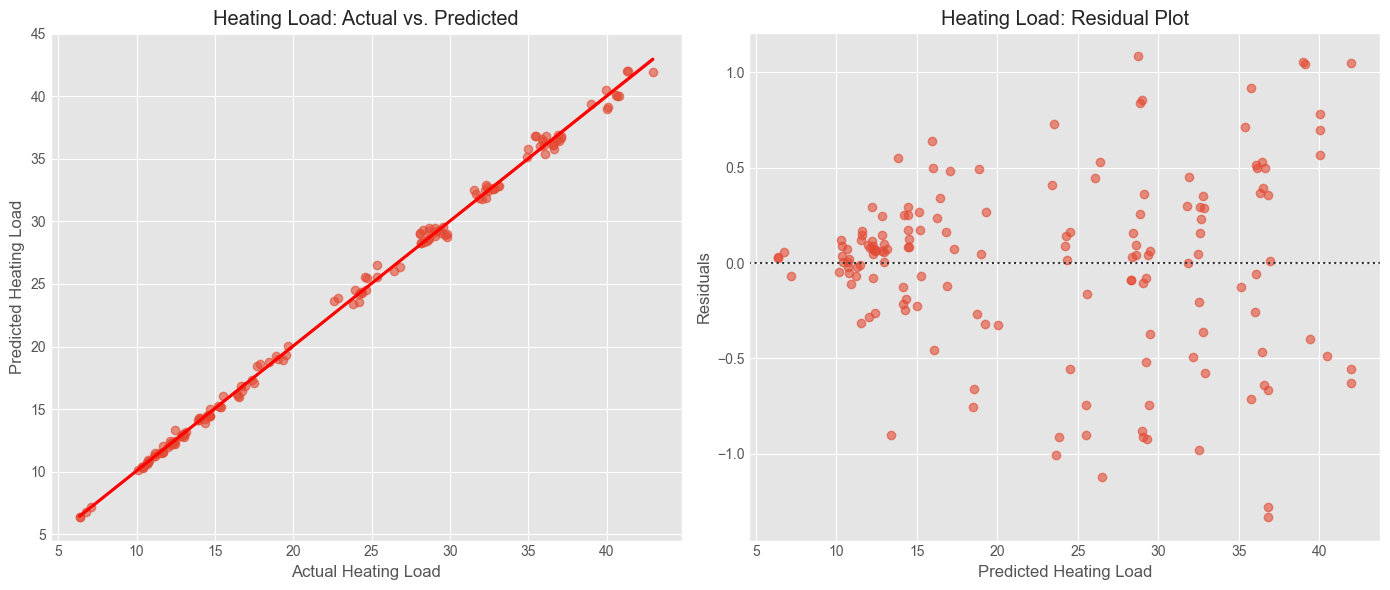

In [82]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.regplot(x=prediction_df['Actual Heating Load'], y=prediction_df['Predicted Heating Load'], scatter_kws={'alpha': 0.6}, 
            line_kws={'color': 'red'})
plt.title('Heating Load: Actual vs. Predicted')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.residplot(x=prediction_df['Predicted Heating Load'], y=prediction_df['Actual Heating Load'], scatter_kws={'alpha': 0.6})
plt.title('Heating Load: Residual Plot')
plt.xlabel('Predicted Heating Load')
plt.ylabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

#### **Analysis of the Plots**
- **Actual vs. Predicted Plot:** The points are very tightly clustered around the red diagonal line (y=x). This visually proves high test $R^2$ score and confirms that model's predictions are extremely close to the actual Heating Load values.

- **Residual Plot:** The residuals (the prediction errors) are randomly scattered around the horizontal zero line. There is no discernible pattern, which is exactly what we want. This confirms that model's errors are random and that it has successfully captured the underlying patterns in the data without any systematic bias.

#### **Heating Load: Residual Distribution Plot** 

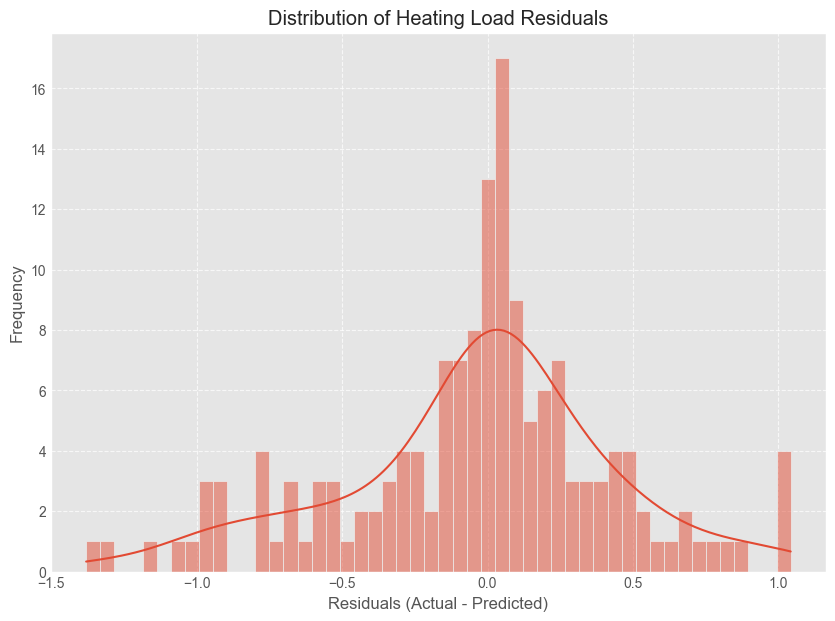

In [87]:
prediction_df['Heating Load Residuals'] = prediction_df['Actual Heating Load'] - prediction_df['Predicted Heating Load']
plt.figure(figsize=(10, 7))
sns.histplot(prediction_df['Heating Load Residuals'], kde=True, bins=50)
plt.title('Distribution of Heating Load Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### **Cooling Load: Actual vs Predicted Plot and Residual Plot**

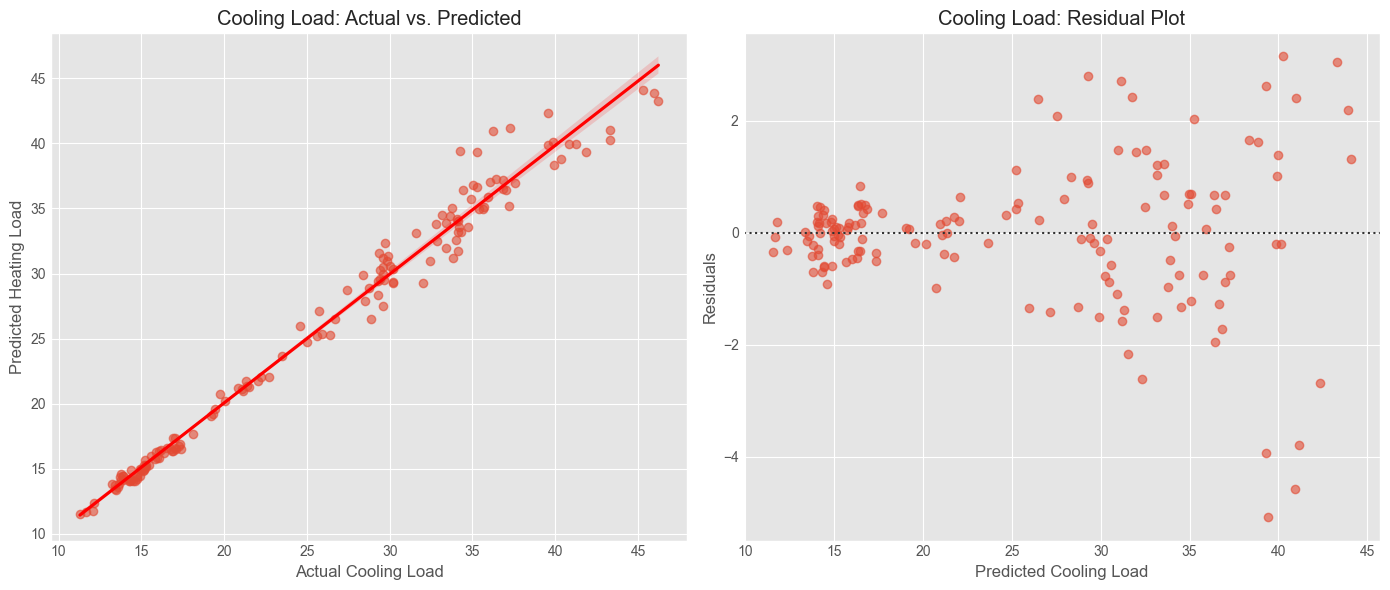

In [88]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.regplot(x=prediction_df['Actual Cooling Load'], y=prediction_df['Predicted Cooling Load'], scatter_kws={'alpha': 0.6}, 
            line_kws={'color': 'red'})
plt.title('Cooling Load: Actual vs. Predicted')
plt.xlabel('Actual Cooling Load')
plt.ylabel('Predicted Heating Load')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.residplot(x=prediction_df['Predicted Cooling Load'], y=prediction_df['Actual Cooling Load'], scatter_kws={'alpha': 0.6})
plt.title('Cooling Load: Residual Plot')
plt.xlabel('Predicted Cooling Load')
plt.ylabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

#### **Analysis of the Plots**
- **Actual vs. Predicted Plot:** The points are very tightly clustered around the red diagonal line (y=x), which is ideal. This visually validates high test $R^2$ score and confirms that model's predictions are highly accurate for the Cooling Load target.

- **Residual Plot:** The residuals are randomly scattered around the horizontal zero line. This confirms that there are no systematic errors in model's predictions. The scatter is slightly wider than the Heating Load plot, which is consistent with the higher MAE and RMSE values we observed, but the lack of a clear pattern is what's most important here.

#### **Cooling Load: Residual Distribution Plot**

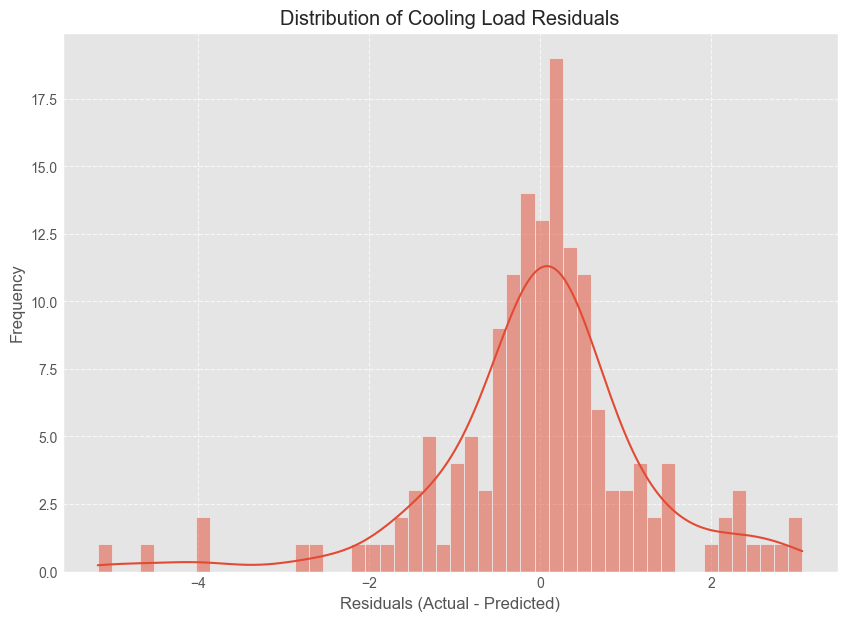

In [89]:
prediction_df['Cooling Load Residuals'] = prediction_df['Actual Cooling Load'] - prediction_df['Predicted Cooling Load']
plt.figure(figsize=(10, 7))
sns.histplot(prediction_df['Cooling Load Residuals'], kde=True, bins=50)
plt.title('Distribution of Cooling Load Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### **Conclusion**
Through a rigorous process of hyperparameter tuning and model ensembling, a single, multi-output stacking regressor was identified as the optimal solution. This model not only provides highly accurate predictions but also a robust and well-generalized performance for both the **Heating Load** and **Cooling Load** targets, making it suitable for real-world application.

#### **Model Saving**

In [91]:
# 1. Define the directory
import os
import joblib
save_dir = 'saved_models'

# 2. Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: '{save_dir}'")
else:
    print(f"Directory '{save_dir}' already exists.")

# 3. Define the full path for your model file
model_filename = os.path.join(save_dir, 'Energy_Efficiency_Project.joblib')

# 4. Save the model
try:
    joblib.dump(multi_target_stacking, model_filename)
    print(f"\nModel successfully saved to: '{model_filename}'")
except Exception as e:
    print(f"Error saving model: {e}")

Directory 'saved_models' already exists.

Model successfully saved to: 'saved_models\Energy_Efficiency_Project.joblib'


In [92]:
# --- How to load the model later ---
# loaded_model = joblib.load(model_filename)
# print("Model loaded successfully!")
# You can then use loaded_model for predictions
# predictions = loaded_model.predict(new_data)

## 7. Project Conclusion

This project successfully addressed the challenge of predicting both **Heating Load** and **Cooling Load** for a set of residential buildings. The final solution is a robust and highly accurate **single stacking regressor model**.

The approach began with a comprehensive data analysis, followed by strategic preprocessing steps. Initial modeling revealed a significant overfitting issue, particularly with the `Cooling_Load` target. To solve this, a multi-model strategy was adopted, involving separate hyperparameter tuning of three powerful algorithms: **XGBoost**, **LightGBM**, and **Random Forest**.

The single stacking regressor, trained on both targets simultaneously, was identified as the optimal solution. This model successfully combined the strengths of its base learners to provide a superior and stable solution. It achieved a **test $R^2$ score of 0.9979 for Heating Load** and **0.9832 for Cooling Load**, with minimal training-testing gaps, confirming its exceptional reliability.

While the current model is highly effective, potential areas for future work include exploring the use of deep learning models, such as neural networks, or incorporating additional features related to building materials or geographic location to potentially improve accuracy even further. Overall, the project demonstrates a complete and professional machine learning workflow, from initial data exploration to the saving of a highly-performant ensemble model.